NMPC implementation for unicycle model dynamics

In [2]:
import casadi as cas
import numpy as np

# Parameters
N = 500  # Prediction horizon
dt = 0.1  # Sampling time (seconds)
v_max = 1.0  # Maximum linear velocity (m/s)
ω_max = np.pi / 4  # Maximum angular velocity (rad/s)
large_number = 1e3  # Large number for unbounded state constraints
x_goal = np.array([0.2, 0.2, 0])
# Define initial state and reference trajectory
x_current = np.array([0.0, 0.0, 0.0])  # [x0, y0, θ0]
X_ref_traj = np.tile(x_goal, (N, 1)).T  # Reach point (1,1) with θ=0
p_value = np.concatenate([x_current, X_ref_traj.ravel()])

# Define the dynamics function
def dynamics(x, u):
    return cas.vertcat(
        x[0] + dt * u[0] * cas.cos(x[2]),  # x_{k+1}
        x[1] + dt * u[0] * cas.sin(x[2]),  # y_{k+1}
        x[2] + dt * u[1]                   # θ_{k+1}
    )

# Define cost matrices (diagonal for simplicity)
Q = cas.diag([1.0, 1.0, 1.0])  # State weighting: [x, y, θ], creates 3x3 diagonal matrix
R = cas.diag([0.1, 0.1])       # Control weighting: [v, ω], creates 2x2 diagonal matrix

# Define symbolic variables
nx = 3  # State dimension
nu = 2  # Control dimension

# Parameters: initial state x0 and reference trajectory X_ref flattened
p = cas.SX.sym('p', nx + nx * N)  # [x0; vec(X_ref)]

# Decision variables: control U and predicted states X flattened
Z = cas.SX.sym('Z', nu * N + nx * N)  # [vec(U); vec(X)]

# Extract variables from Z and p
x0 = p[0:nx]  # Initial state [x0, y0, θ0]
X_ref_vec = p[nx:]  # Vectorized reference trajectory
X_ref = cas.reshape(X_ref_vec, nx, N)  # Reshape to (3, N) for x1 to xN
U = cas.reshape(Z[0:nu * N], nu, N)   # Controls u0 to u_{N-1}, shape (2, N)
X = cas.reshape(Z[nu * N:], nx, N)    # States x1 to xN, shape (3, N)

# Define the cost function
cost = cas.SX(0)
for k in range(N):
    # # State tracking cost: (x_k - x_ref_k)^T Q (x_k - x_ref_k)
    # state_error = X_ref[:, k] - X[:, k]
    # # cost += cas.mtimes([state_error.T, Q, state_error])
    # cost += state_error.T @ Q @ state_error
    # Control effort cost: u_k^T R u_k
    control = U[:, k]
    cost += control.T @ R @ control

cost += 10*((X[0, N-1] - X_ref[0, N-1])**2 + (X[1, N-1] - X_ref[1, N-1])**2)
# Define dynamics constraints
g = []
for k in range(N):
    if k == 0:
        # First step: predict x1 from x0 and u0
        x_pred = dynamics(x0, U[:, 0])
    else:
        # Subsequent steps: predict x_{k+1} from x_k and u_k
        x_pred = dynamics(X[:, k - 1], U[:, k])
    # Constraint: predicted state equals optimization variable
    g.append(X[:, k] - x_pred)


# g.append(X[0, N-1] - x_goal[0]) # Goal constraint
# g.append(X[1, N-1] - x_goal[1]) # Goal constraint
g.append((X[:, N-1] - x_goal)**2) # Goal constraint

# g.append(U[], )
g = cas.vertcat(*g)  # Stack constraints into a single vector (3*N, 1)

# Define the nonlinear programming problem (NLP)
nlp = {
    'x': Z,      # Decision variables
    'p': p,      # Parameters
    'f': cost,   # Objective function
    'g': g       # Constraints
}

# Define bounds
lbz = np.full((nu * N + nx * N,), -large_number)  # Lower bounds for Z
ubz = np.full((nu * N + nx * N,), large_number)   # Upper bounds for Z

# Input constraints: -v_max <= v_k <= v_max, -ω_max <= ω_k <= ω_max
lbz[0:nu * N:2] = -v_max   # v_k lower bounds
ubz[0:nu * N:2] = v_max    # v_k upper bounds
lbz[1:nu * N:2] = -ω_max   # ω_k lower bounds
ubz[1:nu * N:2] = ω_max    # ω_k upper bounds

# Constraint bounds: dynamics equality constraints (g = 0)
lbg = np.zeros(nx * N + 3)  # Lower bounds for g
ubg = np.zeros(nx * N + 3)  # Upper bounds for g

# Create the solver
solver = cas.nlpsol('solver', 'ipopt', nlp)

# Initial guess
Z0 = np.zeros(nu * N + nx * N)

# Solve the optimization problem
sol = solver(x0=Z0, p=p_value, lbx=lbz, ubx=ubz, lbg=lbg, ubg=ubg)
Z_opt = sol['x'].full().flatten()
U_opt = Z_opt[0:nu * N].reshape(N, nu).T
X_opt = Z_opt[nu * N:].reshape(N, nx).T

# First control input to apply
u0 = U_opt[:, 0]
print("Optimal first control:", u0)


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     5498
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2001

Total number of variables............................:     2500
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     2500
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1503
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.00e-02 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

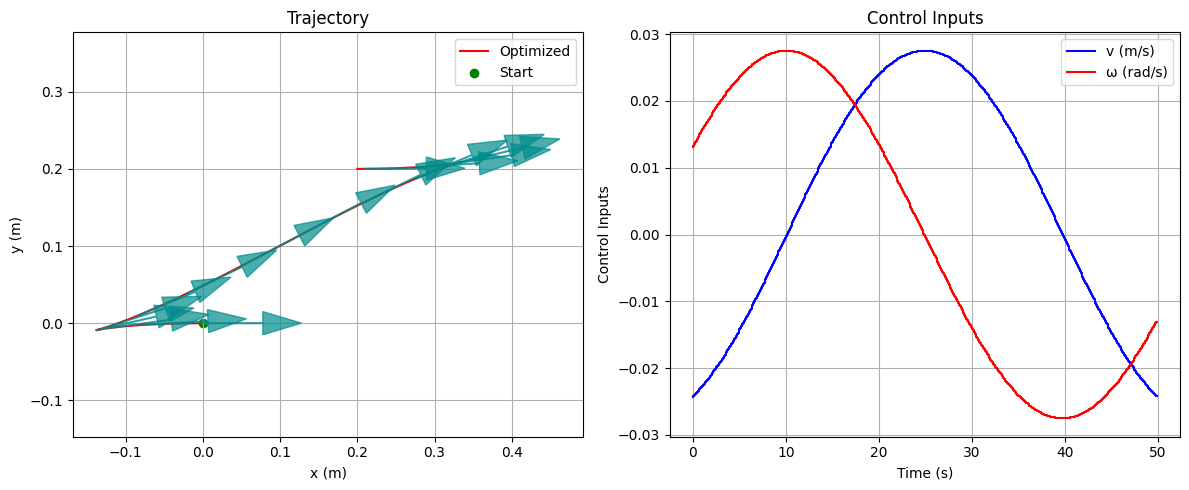

In [3]:
import matplotlib.pyplot as plt
# Plotting
# 1. Plot the (x, y) trajectory
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(X_opt[0, :], X_opt[1, :], 'r-', label='Optimized')
plt.scatter(x_current[0], x_current[1], c='g', marker='o', label='Start')


# --- Add Direction Arrows ---
arrow_length_ratio = 0.08 # Adjust arrow length relative to plot range (or set fixed length like 0.1)
arrow_skip = max(1, N // 15) # Show about 15 arrows along the trajectory
head_width = 0.03
head_length = 0.05
arrow_color = 'darkcyan'

# Determine approximate plot range for scaling arrow length (optional)
x_range = np.ptp(X_opt[0, :]) if N > 1 else 1.0
y_range = np.ptp(X_opt[1, :]) if N > 1 else 1.0
arrow_length = arrow_length_ratio * max(x_range, y_range)
arrow_length = 0.08 # Using fixed length for simplicity

for i in range(0, N, arrow_skip):
    x_pos = X_opt[0, i]
    y_pos = X_opt[1, i]
    theta = X_opt[2, i]
    dx = arrow_length * np.cos(theta)
    dy = arrow_length * np.sin(theta)
    plt.arrow(x_pos, y_pos, dx, dy,
              head_width=head_width,
              head_length=head_length,
              fc=arrow_color, ec=arrow_color,
              alpha=0.7, zorder=4) # Use zorder to place arrows below start/goal markers

plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Trajectory')
plt.legend()
plt.grid(True)
plt.axis('equal')

# 2. Plot the control inputs (v, ω) over the prediction horizon
time_steps = np.arange(N) * dt
plt.subplot(1, 2, 2)
plt.step(time_steps, U_opt[0, :], 'b-', label='v (m/s)')
plt.step(time_steps, U_opt[1, :], 'r-', label='ω (rad/s)')
plt.xlabel('Time (s)')
plt.ylabel('Control Inputs')
plt.title('Control Inputs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1095
Number of nonzeros in inequality constraint Jacobian.:      200
Number of nonzeros in Lagrangian Hessian.............:      599

Total number of variables............................:      500
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      500
                     variables with only upper bounds:        0
Total number of equality constraints.................:      300
Total number of inequality constraints...............:      100
        inequality constraints with only lower bounds:      100
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.0000000e+02 1.00e+00 8.68e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

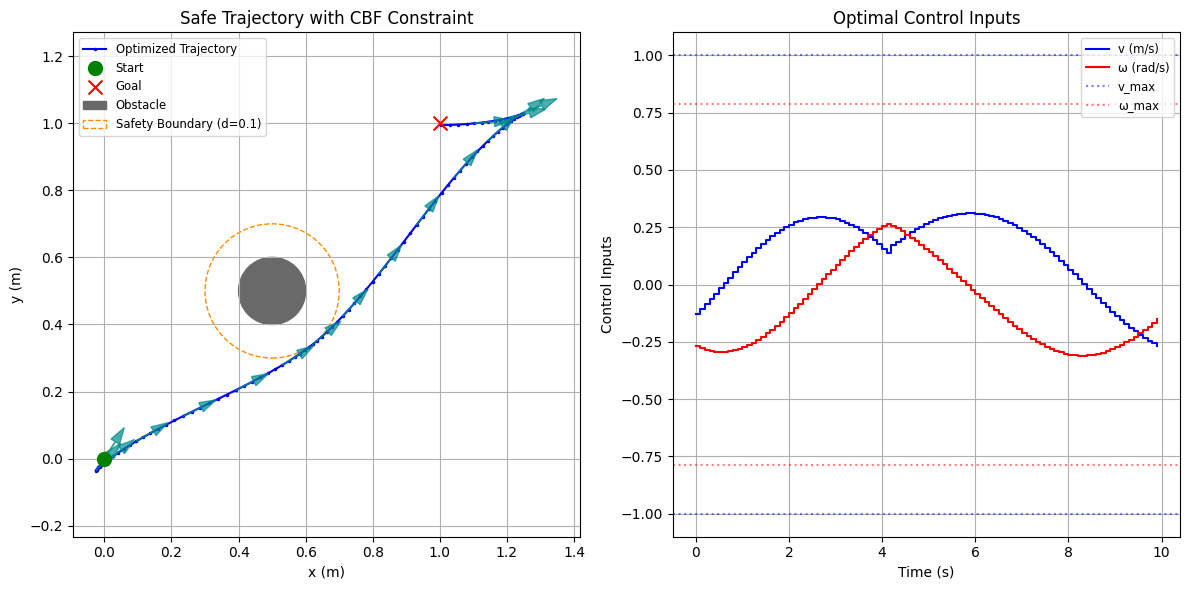

In [7]:
import casadi as cas
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle # Import Circle patch

# Parameters
N = 100  # Prediction horizon (Reduced for faster computation with CBF)
dt = 0.1  # Sampling time (seconds)
v_max = 1.0  # Maximum linear velocity (m/s)
ω_max = np.pi / 4  # Maximum angular velocity (rad/s)
large_number = 1e6  # Large number for unbounded constraints (can use cas.inf)

# Goal
x_goal = np.array([1.0, 1.0, 0.0])

# Define initial state
x_current = np.array([0.0, 0.0, 1.0])  # [x0, y0, θ0]

# Obstacle Parameters
obstacle_center = np.array([0.5, 0.5])
obstacle_radius = 0.1
safe_distance = 0.1 # Minimum distance robot center should maintain from obstacle EDGE
# The robot's center must be >= (obstacle_radius + safe_distance) from the obstacle center
min_dist_from_center_sq = (obstacle_radius + safe_distance)**2

# Reference trajectory (not strictly followed due to obstacle)
# We primarily focus on the final goal cost and obstacle avoidance.
# A reference path could be added, but let's keep it simple.
X_ref_traj = np.tile(x_goal, (N, 1)).T  # Reach point (1,1) with θ=0

# Parameter vector for CasADi (initial state + flattened reference)
p_value = np.concatenate([x_current, X_ref_traj.ravel()])

# Define the dynamics function (discrete time)
def dynamics(x, u):
    return cas.vertcat(
        x[0] + dt * u[0] * cas.cos(x[2]),  # x_{k+1}
        x[1] + dt * u[0] * cas.sin(x[2]),  # y_{k+1}
        x[2] + dt * u[1]                   # θ_{k+1}
    )

# Define cost matrices
Q = cas.diag([1.0, 1.0, 0.1])  # State weighting [x, y, θ] (Reduced theta weight)
R = cas.diag([0.1, 0.1])       # Control weighting [v, ω]

# Define symbolic variables
nx = 3  # State dimension
nu = 2  # Control dimension

# Parameters: initial state x0 and reference trajectory X_ref flattened
p = cas.SX.sym('p', nx + nx * N)  # [x0; vec(X_ref)]

# Decision variables: control U and predicted states X flattened
Z = cas.SX.sym('Z', nu * N + nx * N)  # [vec(U); vec(X)]

# Extract variables from Z and p
x0 = p[0:nx]                # Initial state [x0, y0, θ0]
X_ref_vec = p[nx:]          # Vectorized reference (not heavily used in cost)
X_ref = cas.reshape(X_ref_vec, nx, N) # Reshape to (3, N)
U = cas.reshape(Z[0:nu * N], nu, N)    # Controls u0 to u_{N-1}, shape (2, N)
X = cas.reshape(Z[nu * N:], nx, N)     # States x1 to xN, shape (3, N)

# --- Define the cost function ---
cost = cas.SX(0)
# Primarily minimize control effort
for k in range(N):
    # Control effort cost: u_k^T R u_k
    control = U[:, k]
    cost += control.T @ R @ control

# Strong penalty on final state error (reaching the goal)
final_state_error = X[:, N - 1] - x_goal
cost += 100 * (final_state_error.T @ Q @ final_state_error) # Weighted final error

# --- Define constraints ---
g = [] # Constraint vector
lbg = [] # Lower bounds for constraints
ubg = [] # Upper bounds for constraints

# 1. Dynamics Constraints (x_{k+1} = f(x_k, u_k))
for k in range(N):
    if k == 0:
        # First step: predict x1 from x0 and u0
        x_pred = dynamics(x0, U[:, 0])
    else:
        # Subsequent steps: predict x_{k+1} from x_k and u_k
        x_pred = dynamics(X[:, k - 1], U[:, k])
    # Constraint: predicted state equals optimization variable
    g.append(X[:, k] - x_pred)
    lbg.extend([0.0] * nx) # Equality constraint: lower bound = 0
    ubg.extend([0.0] * nx) # Equality constraint: upper bound = 0

# 2. Control Barrier Function (CBF) Constraints
for k in range(N):
    # Barrier function h(x) = ||pos - obs_center||^2 - min_dist_sq >= 0
    pos_k = X[0:2, k] # Get [x_k, y_k]
    dist_sq = cas.sumsqr(pos_k - obstacle_center) # Squared distance from obstacle center
    h_k = dist_sq - min_dist_from_center_sq # Barrier function value
    g.append(h_k) # Add h(x_k) to the constraint list
    lbg.append(0.0)         # Lower bound h(x_k) >= 0
    ubg.append(cas.inf)     # Upper bound h(x_k) <= infinity

# --- Combine constraints and bounds ---
g = cas.vertcat(*g) # Stack constraints into a single vector
lbg = np.array(lbg)
ubg = np.array(ubg)

# Check if initial state is safe (optional but good practice)
initial_dist_sq = np.sum((x_current[0:2] - obstacle_center)**2)
if initial_dist_sq < min_dist_from_center_sq:
    print(f"Warning: Initial state x={x_current[0]:.2f}, y={x_current[1]:.2f} is already violating the safety distance!")
    # The optimization might fail or give unexpected results.
    # Consider adding a small buffer or checking feasibility more robustly.

# --- Define the nonlinear programming problem (NLP) ---
nlp = {
    'x': Z,      # Decision variables
    'p': p,      # Parameters
    'f': cost,   # Objective function
    'g': g       # Constraints
}

# --- Define bounds for decision variables (Z) ---
lbz = np.full((nu * N + nx * N,), -large_number)  # Lower bounds for Z
ubz = np.full((nu * N + nx * N,), large_number)   # Upper bounds for Z

# Input constraints: -v_max <= v_k <= v_max, -ω_max <= ω_k <= ω_max
# Apply to the U part of Z
lbz[0:nu * N:nu] = -v_max  # v_k lower bounds (indices 0, 2, 4, ...)
ubz[0:nu * N:nu] = v_max   # v_k upper bounds
lbz[1:nu * N:nu] = -ω_max  # ω_k lower bounds (indices 1, 3, 5, ...)
ubz[1:nu * N:nu] = ω_max   # ω_k upper bounds

# --- Create the solver ---
# Solver options can be tuned for performance/robustness
# solver_opts = {'ipopt': {'print_level': 0, 'tol': 1e-4, 'acceptable_tol': 1e-3}} # Example options
solver = cas.nlpsol('solver', 'ipopt', nlp) #, solver_opts)

# --- Solve the optimization problem ---
# Initial guess (zeros often work, but better guesses can speed up convergence)
Z0 = np.zeros(nu * N + nx * N)

sol = solver(x0=Z0, p=p_value, lbx=lbz, ubx=ubz, lbg=lbg, ubg=ubg)
Z_opt = sol['x'].full().flatten()

# --- Extract optimal solution ---
U_opt = Z_opt[0:nu * N].reshape(N, nu).T
X_opt = Z_opt[nu * N:].reshape(N, nx).T

# Prepend the initial state to the optimal state trajectory for plotting
X_plot = np.hstack((x_current.reshape(nx, 1), X_opt))

# First control input to apply (in a real MPC loop)
u0 = U_opt[:, 0]
print("Optimal first control:", u0)
print(f"Final predicted state: x={X_opt[0,-1]:.3f}, y={X_opt[1,-1]:.3f}, theta={X_opt[2,-1]:.3f}")


# --- Plotting ---
plt.figure(figsize=(12, 6))

# 1. Plot the (x, y) trajectory with obstacle
ax1 = plt.subplot(1, 2, 1) # Use ax1 for patches
plt.plot(X_plot[0, :], X_plot[1, :], 'b-', marker='.', markersize=3, label='Optimized Trajectory')
plt.scatter(x_current[0], x_current[1], c='g', marker='o', s=100, label='Start', zorder=5)
plt.scatter(x_goal[0], x_goal[1], c='r', marker='x', s=100, label='Goal', zorder=5)

# Draw the obstacle
obstacle_patch = Circle(obstacle_center, obstacle_radius, color='dimgray', label='Obstacle')
ax1.add_patch(obstacle_patch)

# Draw the safety distance boundary
safety_circle = Circle(obstacle_center, obstacle_radius + safe_distance,
                       color='darkorange', fill=False, linestyle='--',
                       label=f'Safety Boundary (d={safe_distance})')
ax1.add_patch(safety_circle)

# --- Add Direction Arrows (Optional, can clutter the plot) ---
arrow_length_ratio = 0.08
arrow_skip = max(1, N // 15)
head_width = 0.03
head_length = 0.05
arrow_color = 'darkcyan'
arrow_length = 0.06 # Fixed length

for i in range(0, N + 1, arrow_skip): # Include initial state in arrows
    x_pos = X_plot[0, i]
    y_pos = X_plot[1, i]
    theta = X_plot[2, i]
    dx = arrow_length * np.cos(theta)
    dy = arrow_length * np.sin(theta)
    plt.arrow(x_pos, y_pos, dx, dy,
              head_width=head_width, head_length=head_length,
              fc=arrow_color, ec=arrow_color,
              alpha=0.7, zorder=4)

plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Safe Trajectory with CBF Constraint')
plt.legend(fontsize='small')
plt.grid(True)
plt.axis('equal') # Crucial for seeing circles correctly

# 2. Plot the control inputs (v, ω) over the prediction horizon
plt.subplot(1, 2, 2)
time_steps = np.arange(N) * dt
plt.step(time_steps, U_opt[0, :], 'b-', where='post', label='v (m/s)')
plt.step(time_steps, U_opt[1, :], 'r-', where='post', label='ω (rad/s)')
# Draw velocity/acceleration limits
plt.axhline(v_max, color='b', linestyle=':', alpha=0.5, label='v_max')
plt.axhline(-v_max, color='b', linestyle=':', alpha=0.5)
plt.axhline(ω_max, color='r', linestyle=':', alpha=0.5, label='ω_max')
plt.axhline(-ω_max, color='r', linestyle=':', alpha=0.5)

plt.xlabel('Time (s)')
plt.ylabel('Control Inputs')
plt.title('Optimal Control Inputs')
plt.legend(fontsize='small')
plt.grid(True)
plt.ylim([-max(v_max, ω_max)*1.1, max(v_max, ω_max)*1.1]) # Adjust y-limits

plt.tight_layout()
plt.show()

## CBF with CBFs and velocity constraint

Constraining initial control U[:,0] (indices 0, 1) to zero.
Constraining final control U[:,N-1] (indices 198, 199) to zero.
Total number of variables............................:      496
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      196
                     variables with only upper bounds:        0
Total number of equality constraints.................:      303
Total number of inequality constraints...............:      100
        inequality constraints with only lower bounds:      100
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

Cannot call restoration phase at point that is almost feasible (violation 2.220446e-16).
Abort in line search due to no other fall back.

Number of Iterations....: 59

                                   (scaled)                 (unscaled)
Objective...............:   5.2539677228940420e+01    1.0507

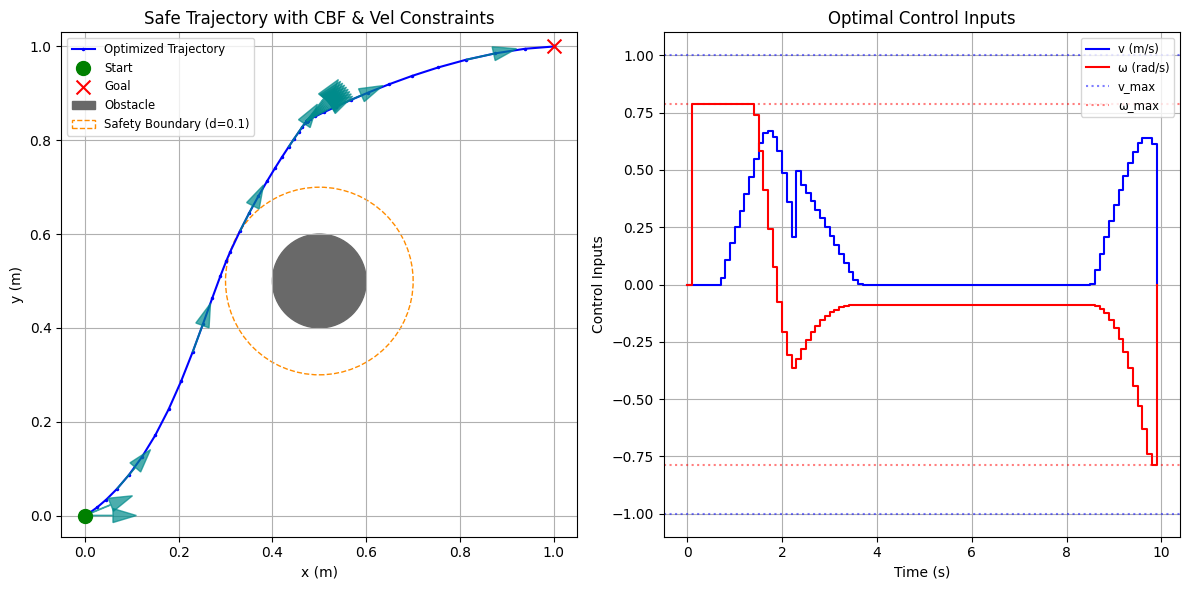

In [3]:
import casadi as cas
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle # Import Circle patch

# Parameters
N = 100  # Prediction horizon
dt = 0.1  # Sampling time (seconds)
v_max = 1.0  # Maximum linear velocity (m/s)
ω_max = np.pi / 4  # Maximum angular velocity (rad/s)
large_number = cas.inf # Use CasADi infinity for bounds

# Goal
x_goal = np.array([1.0, 1.0, 0.0]) # Goal state [x, y, theta]

# Define initial state
x_current = np.array([0.0, 0.0, 0.0])  # [x0, y0, θ0]

# Obstacle Parameters
obstacle_center = np.array([0.5, 0.5])
obstacle_radius = 0.1
safe_distance = 0.1 # Minimum distance robot center should maintain from obstacle EDGE
min_dist_from_center_sq = (obstacle_radius + safe_distance)**2

# Reference trajectory (not strictly used, goal cost is primary driver)
X_ref_traj = np.tile(x_goal, (N, 1)).T
p_value = np.concatenate([x_current, X_ref_traj.ravel()])

# Define the dynamics function (discrete time)
def dynamics(x, u):
    return cas.vertcat(
        x[0] + dt * u[0] * cas.cos(x[2]),  # x_{k+1}
        x[1] + dt * u[0] * cas.sin(x[2]),  # y_{k+1}
        x[2] + dt * u[1]                   # θ_{k+1}
    )

# Define cost matrices
Q = cas.diag([1.0, 1.0, 0])  # State weighting [x, y, θ]
R = cas.diag([1, 1])       # Control weighting [v, ω]

# Define symbolic variables
nx = 3  # State dimension
nu = 2  # Control dimension

# Parameters: initial state x0 and reference trajectory X_ref flattened
p = cas.SX.sym('p', nx + nx * N)  # [x0; vec(X_ref)]

# Decision variables: control U and predicted states X flattened
Z = cas.SX.sym('Z', nu * N + nx * N)  # [vec(U); vec(X)]

# Extract variables from Z and p
x0 = p[0:nx]                # Initial state [x0, y0, θ0]
X_ref_vec = p[nx:]          # Vectorized reference (not used in cost)
X_ref = cas.reshape(X_ref_vec, nx, N) # Reshape to (3, N)
U = cas.reshape(Z[0:nu * N], nu, N)    # Controls u0 to u_{N-1}, shape (2, N)
X = cas.reshape(Z[nu * N:], nx, N)     # States x1 to xN, shape (3, N)

# --- Define the cost function ---
cost = cas.SX(0)
# Minimize control effort (helps find smooth solutions)
for k in range(N - 1):
    control = U[:, k]
    cost += control.T @ R @ control
    # State tracking cost: (x_k - x_ref_k)^T Q (x_k - x_ref_k)
    state_error = X_ref[:, k] - X[:, k]
    # cost += cas.mtimes([state_error.T, Q, state_error])
    cost += state_error.T @ Q @ state_error

# Strong penalty on final state error (reaching the goal)
final_state_error = X[:, N - 1] - x_goal
cost += 100 * (final_state_error.T @ Q @ final_state_error) # Weighted final error

# --- Define constraints ---
g = [] # Constraint vector
lbg = [] # Lower bounds for constraints
ubg = [] # Upper bounds for constraints

# 1. Dynamics Constraints (x_{k+1} = f(x_k, u_k))
for k in range(N):
    x_curr_step = X[:, k-1] if k > 0 else x0 # State at start of interval k
    u_curr_step = U[:, k]                  # Control during interval k
    x_next_pred = dynamics(x_curr_step, u_curr_step) # Predicted state at end of interval
    g.append(X[:, k] - x_next_pred) # Constraint: x_{k+1} - f(x_k, u_k) = 0
    lbg.extend([0.0] * nx) # Equality constraint: lower bound = 0
    ubg.extend([0.0] * nx) # Equality constraint: upper bound = 0

# 2. Control Barrier Function (CBF) Constraints
for k in range(N):
    # Barrier function h(x) = ||pos - obs_center||^2 - min_dist_sq >= 0
    # Apply to the state *at the end* of interval k (state X[:, k])
    pos_k = X[0:2, k] # Get [x_{k+1}, y_{k+1}]
    dist_sq = cas.sumsqr(pos_k - obstacle_center) # Squared distance from obstacle center
    h_k = dist_sq - min_dist_from_center_sq # Barrier function value
    g.append(h_k) # Add h(x_{k+1}) to the constraint list
    lbg.append(0.0)         # Lower bound h(x_{k+1}) >= 0
    ubg.append(large_number)     # Upper bound h(x_{k+1}) <= infinity

# --- Combine constraints and bounds ---
g.append((X[:, N-1] - x_goal)**2) # Goal constraint
lbg.extend([0.0] * nx) # Equality constraint: lower bound = 0
ubg.extend([0.0] * nx) # Equality constraint: upper bound = 0

g = cas.vertcat(*g) # Stack constraints into a single vector
lbg = np.array(lbg)
ubg = np.array(ubg)

# Check if initial state is safe (optional but good practice)
initial_dist_sq = np.sum((x_current[0:2] - obstacle_center)**2)
if initial_dist_sq < min_dist_from_center_sq:
    print(f"Warning: Initial state x={x_current[0]:.2f}, y={x_current[1]:.2f} is violating the safety distance!")

# --- Define the nonlinear programming problem (NLP) ---
nlp = {
    'x': Z,      # Decision variables
    'p': p,      # Parameters
    'f': cost,   # Objective function
    'g': g       # Constraints
}

# --- Define bounds for decision variables (Z) ---
lbz = np.full((nu * N + nx * N,), -large_number)  # Lower bounds for Z
ubz = np.full((nu * N + nx * N,), large_number)   # Upper bounds for Z

# State variable bounds (optional, e.g., workspace limits) - Keep as large_number for now
# Example: lbz[nu*N + 0 : nu*N + nx*N : nx] = -workspace_x_limit
#          ubz[nu*N + 0 : nu*N + nx*N : nx] = workspace_x_limit

# General Input constraints: -v_max <= v_k <= v_max, -ω_max <= ω_k <= ω_max
# Apply to the U part of Z for k = 0 to N-1
for k in range(N):
    lbz[k*nu + 0] = 0   # v_k lower bound
    ubz[k*nu + 0] = v_max    # v_k upper bound
    lbz[k*nu + 1] = -ω_max   # ω_k lower bound
    ubz[k*nu + 1] = ω_max    # ω_k upper bound

# --- Add Specific Velocity Constraints by overriding bounds ---

# Initial Velocity Constraint: U[:, 0] = [0, 0]
# Indices for U[:, 0] are 0 and 1 in Z
lbz[0] = 0.0 # v_0 lower bound
ubz[0] = 0.0 # v_0 upper bound
lbz[1] = 0.0 # ω_0 lower bound
ubz[1] = 0.0 # ω_0 upper bound
print(f"Constraining initial control U[:,0] (indices 0, 1) to zero.")

# Final Velocity Constraint: U[:, N-1] = [0, 0]
# Indices for U[:, N-1] are nu*(N-1) and nu*(N-1)+1 in Z
final_v_idx = nu * (N - 1)
final_w_idx = nu * (N - 1) + 1
lbz[final_v_idx] = 0.0 # v_{N-1} lower bound
ubz[final_v_idx] = 0.0 # v_{N-1} upper bound
lbz[final_w_idx] = 0.0 # ω_{N-1} lower bound
ubz[final_w_idx] = 0.0 # ω_{N-1} upper bound
print(f"Constraining final control U[:,N-1] (indices {final_v_idx}, {final_w_idx}) to zero.")


# --- Create the solver ---
solver_opts = {'ipopt': {'print_level': 3, 'sb': 'yes', 'max_iter': 1000, 'tol': 1e-4}} # Adjust print_level (0=silent, 5=verbose)
solver = cas.nlpsol('solver', 'ipopt', nlp, solver_opts)

# --- Solve the optimization problem ---
# Initial guess
Z0 = np.zeros(nu * N + nx * N)

try:
    sol = solver(x0=Z0, p=p_value, lbx=lbz, ubx=ubz, lbg=lbg, ubg=ubg)
    Z_opt = sol['x'].full().flatten()
    stats = solver.stats()
    if stats['success']:
        print("Solver found optimal solution.")
    else:
        print(f"Solver finished with status: {stats['return_status']}")
        # You might want to analyze why it failed (e.g., infeasible)

    # --- Extract optimal solution ---
    U_opt = Z_opt[0:nu * N].reshape(N, nu).T
    X_opt = Z_opt[nu * N:].reshape(N, nx).T

    # Prepend the initial state to the optimal state trajectory for plotting
    X_plot = np.hstack((x_current.reshape(nx, 1), X_opt))

    # First control input to apply (in a real MPC loop)
    u0 = U_opt[:, 0]
    print(f"Optimal first control: {u0}") # Should be [0, 0] due to constraint
    print(f"Optimal last control: {U_opt[:, -1]}") # Should be [0, 0] due to constraint
    print(f"Final predicted state: x={X_opt[0,-1]:.3f}, y={X_opt[1,-1]:.3f}, theta={X_opt[2,-1]:.3f}")


    # --- Plotting ---
    plt.figure(figsize=(12, 6))

    # 1. Plot the (x, y) trajectory with obstacle
    ax1 = plt.subplot(1, 2, 1) # Use ax1 for patches
    plt.plot(X_plot[0, :], X_plot[1, :], 'b-', marker='.', markersize=3, label='Optimized Trajectory')
    plt.scatter(x_current[0], x_current[1], c='g', marker='o', s=100, label='Start', zorder=5)
    plt.scatter(x_goal[0], x_goal[1], c='r', marker='x', s=100, label='Goal', zorder=5)

    # Draw the obstacle
    obstacle_patch = Circle(obstacle_center, obstacle_radius, color='dimgray', label='Obstacle')
    ax1.add_patch(obstacle_patch)

    # Draw the safety distance boundary
    safety_circle = Circle(obstacle_center, obstacle_radius + safe_distance,
                           color='darkorange', fill=False, linestyle='--',
                           label=f'Safety Boundary (d={safe_distance})')
    ax1.add_patch(safety_circle)

    # --- Add Direction Arrows (Optional, can clutter the plot) ---
    arrow_length_ratio = 0.08
    arrow_skip = max(1, N // 15)
    head_width = 0.03
    head_length = 0.05
    arrow_color = 'darkcyan'
    arrow_length = 0.06 # Fixed length

    for i in range(0, N + 1, arrow_skip): # Include initial state in arrows
        x_pos = X_plot[0, i]
        y_pos = X_plot[1, i]
        theta = X_plot[2, i]
        dx = arrow_length * np.cos(theta)
        dy = arrow_length * np.sin(theta)
        plt.arrow(x_pos, y_pos, dx, dy,
                head_width=head_width, head_length=head_length,
                fc=arrow_color, ec=arrow_color,
                alpha=0.7, zorder=4)
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title('Safe Trajectory with CBF & Vel Constraints')
    plt.legend(fontsize='small')
    plt.grid(True)
    plt.axis('equal') # Crucial for seeing circles correctly

    # 2. Plot the control inputs (v, ω) over the prediction horizon
    plt.subplot(1, 2, 2)
    time_steps = np.arange(N) * dt
    plt.step(time_steps, U_opt[0, :], 'b-', where='post', label='v (m/s)')
    plt.step(time_steps, U_opt[1, :], 'r-', where='post', label='ω (rad/s)')
    # Draw velocity/acceleration limits
    plt.axhline(v_max, color='b', linestyle=':', alpha=0.5, label='v_max')
    plt.axhline(-v_max, color='b', linestyle=':', alpha=0.5)
    plt.axhline(ω_max, color='r', linestyle=':', alpha=0.5, label='ω_max')
    plt.axhline(-ω_max, color='r', linestyle=':', alpha=0.5)

    plt.xlabel('Time (s)')
    plt.ylabel('Control Inputs')
    plt.title('Optimal Control Inputs')
    plt.legend(fontsize='small')
    plt.grid(True)
    plt.ylim([-max(v_max, ω_max)*1.1, max(v_max, ω_max)*1.1]) # Adjust y-limits

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"An error occurred during optimization: {e}")
    # This might happen if the problem becomes infeasible due to constraints

## Same as above but with multiple goals

Using 25 obstacles.
Constraining initial control U[:,0] (indices 0, 1) to zero.


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.



--- Starting Solver ---
Total number of variables............................:      498
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      198
                     variables with only upper bounds:        0
Total number of equality constraints.................:      300
Total number of inequality constraints...............:     2503
        inequality constraints with only lower bounds:     2500
   inequality constraints with lower and upper bounds:        3
        inequality constraints with only upper bounds:        0


Number of Iterations....: 473

                                   (scaled)                 (unscaled)
Objective...............:   5.7872817960790360e+02    5.7872817960790360e+02
Dual infeasibility......:   5.7302661155352572e+00    5.7302661155352572e+00
Constraint violation....:   9.8377628953628411e-03    9.8377628953628411e-03
Variable bound violation:   5.5970709178509992e-09    5.59707091

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


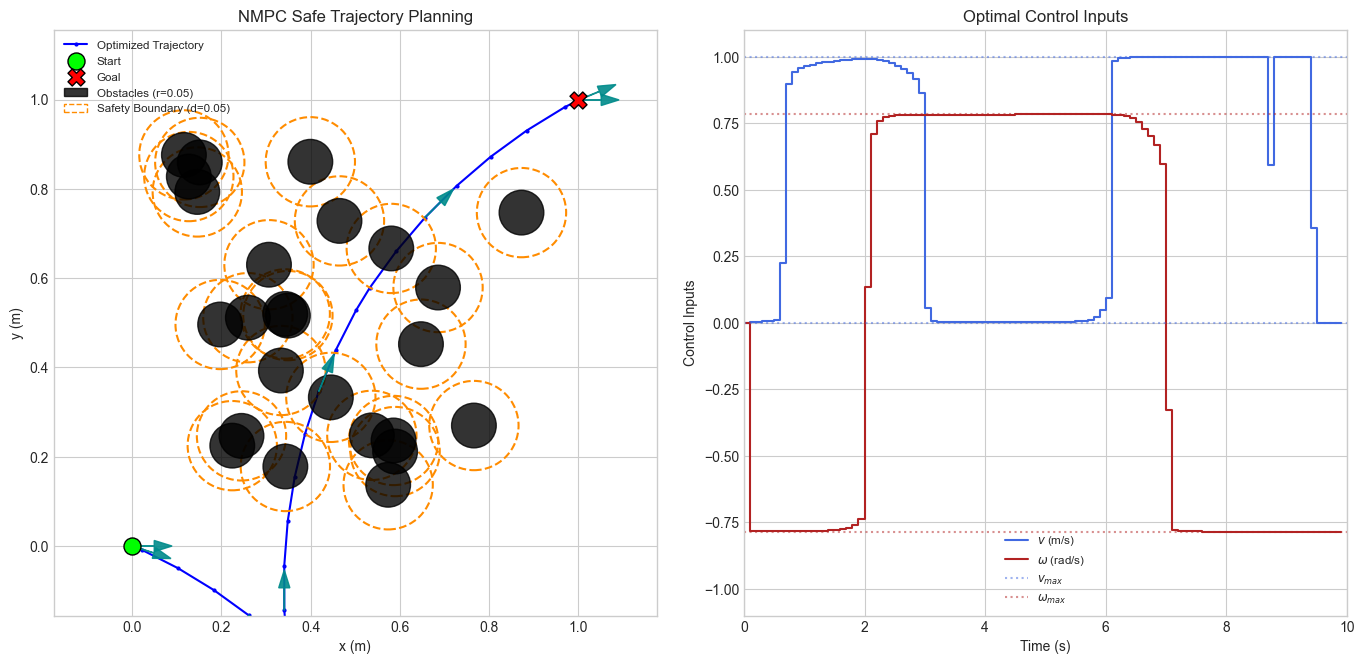

In [23]:
import casadi as cas
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle # Import Circle patch
import time # To time the solver

# Parameters
N = 100  # Prediction horizon
dt = 0.1  # Sampling time (seconds)
v_max = 1.0  # Maximum linear velocity (m/s)
ω_max = np.pi / 4  # Maximum angular velocity (rad/s)
large_number = cas.inf # Use CasADi infinity for bounds

# Goal
x_goal = np.array([1.0, 1.0, 0.0]) # Goal state [x, y, theta]

# Define initial state
x_current = np.array([0.0, 0.0, 0.0])  # [x0, y0, θ0]

# --- Obstacle Parameters ---
num_obstacles = 25
obstacle_radius = 0.05 # Radius of the physical obstacle
safe_distance = 0.05  # Minimum distance robot center should maintain from obstacle EDGE
# Let safe_distance be very similar to radius, e.g., equal
# minimum distance from *center* = obstacle_radius + safe_distance
min_dist_from_center = obstacle_radius + safe_distance

# Generate obstacle centers (avoiding start/goal vicinity)
np.random.seed(42) # for reproducibility
obstacle_centers = np.random.rand(num_obstacles, 2) * 0.8 + 0.1 # Spread in [0.1, 0.9] box
# Ensure obstacles are not too close to start or goal initially (simple check)
min_start_goal_dist = 0.2
obstacle_centers = obstacle_centers[np.linalg.norm(obstacle_centers - x_current[:2], axis=1) > min_start_goal_dist]
obstacle_centers = obstacle_centers[np.linalg.norm(obstacle_centers - x_goal[:2], axis=1) > min_start_goal_dist]
# Recalculate num_obstacles if any were removed
num_obstacles = obstacle_centers.shape[0]
print(f"Using {num_obstacles} obstacles.")

# Pre-calculate minimum squared distances from centers
min_dist_sq_array = np.full(num_obstacles, min_dist_from_center**2)

# Check if initial state is safe
initial_violations = []
for i in range(num_obstacles):
    initial_dist_sq = np.sum((x_current[0:2] - obstacle_centers[i])**2)
    if initial_dist_sq < min_dist_sq_array[i]:
        initial_violations.append(i)
if initial_violations:
    print(f"Warning: Initial state x={x_current[0]:.2f}, y={x_current[1]:.2f} violates safety distance for obstacles: {initial_violations}")
# --- End Obstacle Parameters ---


# Reference trajectory (not strictly used, goal cost is primary driver)
X_ref_traj = np.tile(x_goal, (N, 1)).T
p_value = np.concatenate([x_current, X_ref_traj.ravel()])

# Define the dynamics function (discrete time)
def dynamics(x, u):
    return cas.vertcat(
        x[0] + dt * u[0] * cas.cos(x[2]),  # x_{k+1}
        x[1] + dt * u[0] * cas.sin(x[2]),  # y_{k+1}
        x[2] + dt * u[1]                    # θ_{k+1}
    )

# Define cost matrices
Q = cas.diag([1.0, 1.0, 0.1])  # State weighting [x, y, θ] - Added small theta cost
R = cas.diag([1.0, 1.0])       # Control weighting [v, ω]

# Define symbolic variables
nx = 3  # State dimension
nu = 2  # Control dimension

# Parameters: initial state x0 and reference trajectory X_ref flattened
p = cas.SX.sym('p', nx + nx * N)  # [x0; vec(X_ref)]

# Decision variables: control U and predicted states X flattened
Z = cas.SX.sym('Z', nu * N + nx * N)  # [vec(U); vec(X)]

# Extract variables from Z and p
x0 = p[0:nx]              # Initial state [x0, y0, θ0]
# X_ref_vec = p[nx:]          # Vectorized reference (not used in cost)
# X_ref = cas.reshape(X_ref_vec, nx, N) # Reshape to (3, N)
U = cas.reshape(Z[0:nu * N], nu, N)    # Controls u0 to u_{N-1}, shape (2, N)
X = cas.reshape(Z[nu * N:], nx, N)     # States x1 to xN, shape (3, N)

# --- Define the cost function ---
cost = cas.SX(0)
# Minimize control effort (helps find smooth solutions)
for k in range(N): # Iterate up to N-1 for U, but include X[:,N-1] state cost later
    control = U[:, k]
    cost += control.T @ R @ control
    # State cost relative to goal (encourage moving towards goal)
    state_error = X[:, k] - x_goal # Error w.r.t final goal
    cost += state_error.T @ Q @ state_error

# Strong penalty on final state error (reaching the goal) - Already included in loop for k=N-1

# --- Define constraints ---
g = [] # Constraint vector
lbg = [] # Lower bounds for constraints
ubg = [] # Upper bounds for constraints

# 1. Dynamics Constraints (x_{k+1} = f(x_k, u_k))
for k in range(N):
    x_curr_step = X[:, k-1] if k > 0 else x0 # State at start of interval k
    u_curr_step = U[:, k]                   # Control during interval k
    x_next_pred = dynamics(x_curr_step, u_curr_step) # Predicted state at end of interval
    g.append(X[:, k] - x_next_pred) # Constraint: x_{k+1} - f(x_k, u_k) = 0
    lbg.extend([0.0] * nx) # Equality constraint: lower bound = 0
    ubg.extend([0.0] * nx) # Equality constraint: upper bound = 0

# 2. Control Barrier Function (CBF) Constraints for MULTIPLE obstacles
for k in range(N): # For each time step in the prediction horizon
    pos_k = X[0:2, k] # Predicted position [x_{k+1}, y_{k+1}] at the END of step k
    for obs_idx in range(num_obstacles): # For each obstacle
        obs_center = obstacle_centers[obs_idx, :]
        min_dist_sq = min_dist_sq_array[obs_idx]

        # Barrier function h(x) = ||pos - obs_center||^2 - min_dist_sq >= 0
        dist_sq = cas.sumsqr(pos_k - obs_center) # Squared distance from obstacle center
        h_k_obs = dist_sq - min_dist_sq          # Barrier function value for this obstacle

        g.append(h_k_obs)      # Add h(x_{k+1}) >= 0 constraint for this obstacle
        lbg.append(0.0)        # Lower bound h(x_{k+1}) >= 0
        ubg.append(large_number)        # Upper bound h(x_{k+1}) <= infinity

# --- Combine constraints and bounds ---
# Optional: Add explicit final state constraint (can sometimes help convergence)
g.append(X[:, N-1] - x_goal) # Goal constraint X_N = x_goal
lbg.extend([-1e-3] * nx) # Allow small tolerance
ubg.extend([1e-3] * nx)

g = cas.vertcat(*g) # Stack constraints into a single vector
lbg = np.array(lbg)
ubg = np.array(ubg)


# --- Define the nonlinear programming problem (NLP) ---
nlp = {
    'x': Z,      # Decision variables
    'p': p,      # Parameters
    'f': cost,   # Objective function
    'g': g       # Constraints
}

# --- Define bounds for decision variables (Z) ---
lbz = np.full((nu * N + nx * N,), -large_number)  # Lower bounds for Z
ubz = np.full((nu * N + nx * N,), large_number)   # Upper bounds for Z

# State variable bounds (optional, e.g., workspace limits) - Keep as large_number for now

# General Input constraints: 0 <= v_k <= v_max, -ω_max <= ω_k <= ω_max
# Apply to the U part of Z for k = 0 to N-1
for k in range(N):
    lbz[k*nu + 0] = 0      # v_k lower bound (non-negative velocity)
    ubz[k*nu + 0] = v_max     # v_k upper bound
    lbz[k*nu + 1] = -ω_max    # ω_k lower bound
    ubz[k*nu + 1] = ω_max     # ω_k upper bound

# --- Add Specific Velocity Constraints ---
# Initial Velocity Constraint: U[:, 0] = [0, 0]
lbz[0] = 0.0 # v_0 lower bound
ubz[0] = 0.0 # v_0 upper bound
lbz[1] = 0.0 # ω_0 lower bound
ubz[1] = 0.0 # ω_0 upper bound
print(f"Constraining initial control U[:,0] (indices 0, 1) to zero.")

# # Final Velocity Constraint: U[:, N-1] = [0, 0]
# final_v_idx = nu * (N - 1)
# final_w_idx = nu * (N - 1) + 1
# lbz[final_v_idx] = 0.0 # v_{N-1} lower bound
# ubz[final_v_idx] = 0.0 # v_{N-1} upper bound
# lbz[final_w_idx] = 0.0 # ω_{N-1} lower bound
# ubz[final_w_idx] = 0.0 # ω_{N-1} upper bound
# print(f"Constraining final control U[:,N-1] (indices {final_v_idx}, {final_w_idx}) to zero.")


# --- Create the solver ---
# Adjust solver options if needed (e.g., increase max_iter if convergence issues)
solver_opts = {'ipopt': {'print_level': 3, 'sb': 'yes', 'max_iter': 2000, 'tol': 1e-4}}
solver = cas.nlpsol('solver', 'ipopt', nlp, solver_opts)

# --- Solve the optimization problem ---
# Initial guess
Z0 = np.zeros(nu * N + nx * N)
# # Provide a slightly better guess: linear interpolation towards goal for state
# for k in range(N):
#     alpha = (k + 1) / N
#     interp_state = (1 - alpha) * x_current + alpha * x_goal
#     Z0[nu * N + k * nx : nu * N + (k + 1) * nx] = interp_state


print("\n--- Starting Solver ---")
start_time = time.time()
try:
    sol = solver(x0=Z0, p=p_value, lbx=lbz, ubx=ubz, lbg=lbg, ubg=ubg)
    solve_time = time.time() - start_time
    Z_opt = sol['x'].full().flatten()
    stats = solver.stats()
    if stats['success']:
        print(f"Solver found optimal solution in {solve_time:.2f} seconds.")
    else:
        print(f"Solver finished with status: {stats['return_status']} in {solve_time:.2f} seconds.")
        # Analyze failure (e.g., infeasible, max iterations)

    # --- Extract optimal solution ---
    U_opt = Z_opt[0:nu * N].reshape(N, nu).T
    X_opt = Z_opt[nu * N:].reshape(N, nx).T

    # Prepend the initial state to the optimal state trajectory for plotting
    X_plot = np.hstack((x_current.reshape(nx, 1), X_opt))

    # First control input to apply (in a real MPC loop)
    u0 = U_opt[:, 0]
    print(f"Optimal first control: {u0}") # Should be [0, 0] due to constraint
    print(f"Optimal last control: {U_opt[:, -1]}") # Should be [0, 0] due to constraint
    print(f"Final predicted state: x={X_opt[0,-1]:.3f}, y={X_opt[1,-1]:.3f}, theta={X_opt[2,-1]:.3f}")
    final_goal_dist = np.linalg.norm(X_opt[:2, -1] - x_goal[:2])
    print(f"Distance to goal position at final step: {final_goal_dist:.4f}")


    # --- Plotting ---
    plt.style.use('seaborn-v0_8-whitegrid') # Use a clean style
    plt.figure(figsize=(14, 7))

    # 1. Plot the (x, y) trajectory with MULTIPLE obstacles
    ax1 = plt.subplot(1, 2, 1)
    plt.plot(X_plot[0, :], X_plot[1, :], 'b-', marker='.', markersize=4, linewidth=1.5, label='Optimized Trajectory')
    plt.scatter(x_current[0], x_current[1], c='lime', marker='o', s=150, label='Start', zorder=10, edgecolors='black')
    plt.scatter(x_goal[0], x_goal[1], c='red', marker='X', s=150, label='Goal', zorder=10, edgecolors='black')

    # Draw the obstacles and safety boundaries
    for i in range(num_obstacles):
        obs_center_plot = obstacle_centers[i]
        # Obstacle body
        obstacle_patch = Circle(obs_center_plot, obstacle_radius, color='black', alpha=0.8, zorder=5)
        ax1.add_patch(obstacle_patch)
        # Safety boundary
        safety_circle = Circle(obs_center_plot, min_dist_from_center,
                               color='darkorange', fill=False, linestyle='--', linewidth=1.5,
                               zorder=4)
        ax1.add_patch(safety_circle)

    # Add dummy patches for legend clarity
    ax1.add_patch(Circle((0,0), 0.01, color='black', alpha=0.8, label=f'Obstacles (r={obstacle_radius})'))
    ax1.add_patch(Circle((0,0), 0.01, color='darkorange', fill=False, linestyle='--', label=f'Safety Boundary (d={safe_distance})'))


    # --- Add Direction Arrows (Optional) ---
    arrow_skip = max(1, N // 20) # Show fewer arrows
    head_width = 0.025
    head_length = 0.04
    arrow_color = 'darkcyan'
    arrow_length = 0.05 # Fixed length

    for i in range(0, N + 1, arrow_skip):
        x_pos = X_plot[0, i]
        y_pos = X_plot[1, i]
        theta = X_plot[2, i]
        dx = arrow_length * np.cos(theta)
        dy = arrow_length * np.sin(theta)
        plt.arrow(x_pos, y_pos, dx, dy,
                  head_width=head_width, head_length=head_length,
                  fc=arrow_color, ec=arrow_color,
                  alpha=0.9, zorder=6)
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title('NMPC Safe Trajectory Planning')
    plt.legend(fontsize='small', loc='upper left')
    #plt.grid(True)
    plt.axis('equal') # Crucial for seeing circles correctly
    plt.xlim(-0.1, 1.1) # Adjust limits if needed
    plt.ylim(-0.1, 1.1)


    # 2. Plot the control inputs (v, ω) over the prediction horizon
    plt.subplot(1, 2, 2)
    time_steps = np.arange(N) * dt
    plt.step(time_steps, U_opt[0, :], color='royalblue', where='post', linewidth=1.5, label='$v$ (m/s)')
    plt.step(time_steps, U_opt[1, :], color='firebrick', where='post', linewidth=1.5, label='$\\omega$ (rad/s)')
    # Draw velocity/acceleration limits
    plt.axhline(v_max, color='royalblue', linestyle=':', alpha=0.5, label='$v_{max}$')
    plt.axhline(0, color='royalblue', linestyle=':', alpha=0.5) # Lower bound for v
    plt.axhline(ω_max, color='firebrick', linestyle=':', alpha=0.5, label='$\\omega_{max}$')
    plt.axhline(-ω_max, color='firebrick', linestyle=':', alpha=0.5)

    plt.xlabel('Time (s)')
    plt.ylabel('Control Inputs')
    plt.title('Optimal Control Inputs')
    plt.legend(fontsize='small')
    #plt.grid(True)
    plt.ylim([-max(v_max, ω_max)*1.1, max(v_max, ω_max)*1.1]) # Adjust y-limits
    plt.xlim(0, N*dt)

    plt.tight_layout(pad=2.0)
    plt.show()

except Exception as e:
    print(f"\n--- ERROR ---")
    print(f"An error occurred during optimization or post-processing: {e}")
    import traceback
    traceback.print_exc()
    # This might happen if the problem becomes infeasible (e.g., obstacles block goal)
    # or if IPOPT encounters numerical difficulties.

Constraining initial control U[:,0] (indices 0, 1) to zero.

--- Starting Solver ---
Total number of variables............................:      998
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      398
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:      203
        inequality constraints with only lower bounds:      200
   inequality constraints with lower and upper bounds:        3
        inequality constraints with only upper bounds:        0



Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.



Number of Iterations....: 152

                                   (scaled)                 (unscaled)
Objective...............:   1.6809470531682200e-01    1.6809470531682200e-01
Dual infeasibility......:   4.0779088817244036e-07    4.0779088817244036e-07
Constraint violation....:   4.4590131587085580e-10    4.4590131587085580e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0910004109503552e-06    9.0910004109503552e-06
Overall NLP error.......:   9.0910004109503552e-06    9.0910004109503552e-06


Number of objective function evaluations             = 156
Number of objective gradient evaluations             = 153
Number of equality constraint evaluations            = 156
Number of inequality constraint evaluations          = 156
Number of equality constraint Jacobian evaluations   = 153
Number of inequality constraint Jacobian evaluations = 153
Number of Lagrangian Hessian evaluations             = 152
Total seconds in IPO

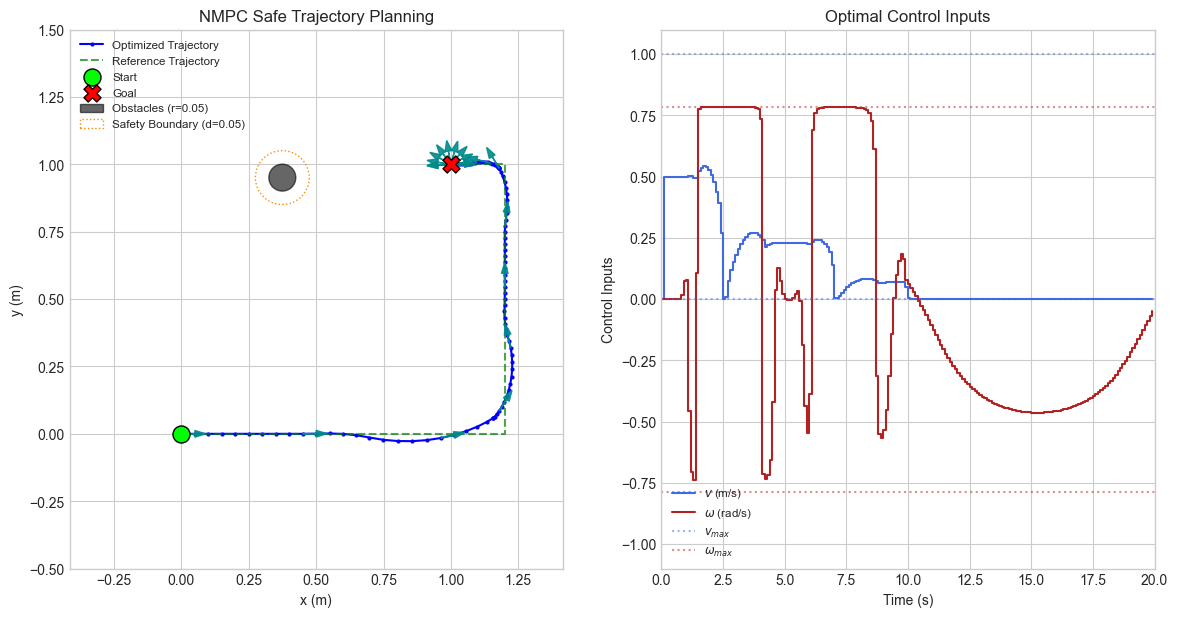

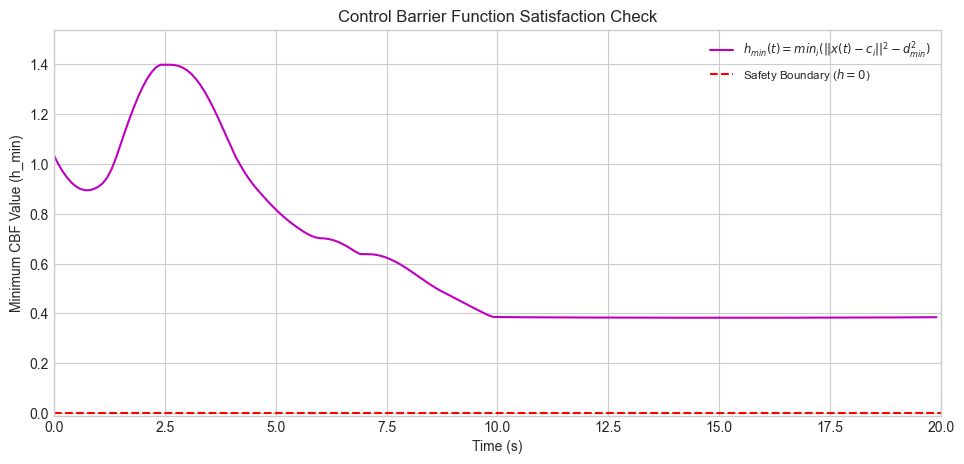


Mean Absolute Position Error: 0.0060 m
Max Absolute Position Error:  0.0726 m
Mean Absolute Orientation Error: 0.8378 rad
Max Absolute Orientation Error:  3.1416 rad


In [ ]:
import casadi as cas
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle # Import Circle patch
import time # To time the solver

# Parameters
N = 200  # Prediction horizon (MAKE SURE N IS LARGE ENOUGH FOR REFERENCE)
dt = 0.1  # Sampling time (seconds)
v_max = 1.0  # Maximum linear velocity (m/s)
ω_max = np.pi / 4  # Maximum angular velocity (rad/s) (~45 deg/s)
large_number = cas.inf # Use CasADi infinity for bounds

# Goal
x_goal = np.array([1.0, 1.0, 0.0]) # Goal state [x, y, theta]

# Define initial state
x_current = np.array([0.0, 0.0, 0.0])  # [x0, y0, θ0]

# --- Obstacle Parameters ---
num_obstacles = 1 # Increased number
obstacle_radius = 0.05 # Radius of the physical obstacle
safe_distance = 0.05   # Minimum distance robot center should maintain from obstacle EDGE
min_dist_from_center = obstacle_radius + safe_distance

# Generate obstacle centers (avoiding start/goal vicinity)
np.random.seed(42) # for reproducibility
obstacle_centers = np.random.rand(num_obstacles, 2) * 1.0 # Spread in [0, 1] box more broadly

# Pre-calculate minimum squared distances from centers
min_dist_sq_array = np.full(num_obstacles, min_dist_from_center**2)

# --- Define Reference Trajectory ---
nx = 3  # State dimension (needed here)
wp0 = np.array([0.0, 0.0, 0.0])      # Start
wp1 = np.array([1.2, 0.0, 0.0])      # Waypoint 1 (end of first segment)
wp2 = np.array([1.2, 1.0, np.pi/2])  # Waypoint 2 (end of second segment)
wp3 = np.array([1.0, 1.0, np.pi])      # Waypoint 3 (final goal)

N1 = 25  # Steps for segment 1 + start turn 2
N2 = 45  # Steps for segment 2 + start turn 3
N3 = 30  # Steps for segment 3 + approach goal

if N1 + N2 + N3 > N:
    print(f"Warning: N1+N2+N3 = {N1+N2+N3} > N = {N}. Adjust steps or N.")
    # Simple fix: scale down (might make segments too short)
    scale = N / (N1 + N2 + N3)
    N1 = int(N1 * scale)
    N2 = int(N2 * scale)
    N3 = N - N1 - N2 # Ensure total is N 
    print(f"Adjusted steps: N1={N1}, N2={N2}, N3={N3}")


X_ref_traj = np.zeros((nx, N))

# Segment 1: (0,0) -> (0.7,0), aiming for theta=0
t1 = np.linspace(0, 1, N1)
X_ref_traj[0, :N1] = wp0[0] + (wp1[0] - wp0[0]) * t1
X_ref_traj[1, :N1] = wp0[1] # y=0
X_ref_traj[2, :N1] = wp1[2] # Target theta=0 for this segment

# Segment 2: (0.7,0) -> (0.7,1), aiming for theta=pi/2
t2 = np.linspace(0, 1, N2)
k_start_2 = N1
k_end_2 = N1 + N2
X_ref_traj[0, k_start_2:k_end_2] = wp1[0] # x=0.7
X_ref_traj[1, k_start_2:k_end_2] = wp1[1] + (wp2[1] - wp1[1]) * t2
X_ref_traj[2, k_start_2:k_end_2] = wp2[2] # Target theta=pi/2 for this segment

# Segment 3: (0.7,1) -> (1.0,1), aiming for theta=0
t3 = np.linspace(0, 1, N3)
k_start_3 = N1 + N2
k_end_3 = N1 + N2 + N3 # Should be <= N
X_ref_traj[0, k_start_3:k_end_3] = wp2[0] + (wp3[0] - wp2[0]) * t3
X_ref_traj[1, k_start_3:k_end_3] = wp2[1] # y=1.0
X_ref_traj[2, k_start_3:k_end_3] = wp3[2] # Target theta=0 for this segment

# Fill remaining steps with goal state if N > N1+N2+N3 (shouldn't happen with adjustment)
if k_end_3 < N:
    X_ref_traj[:, k_end_3:] = wp3.reshape(nx, 1)

# Define symbolic variables
nu = 2  # Control dimension

# --- IMPORTANT: Parameters ---
# Parameter vector 'p' now contains initial state AND reference trajectory
p = cas.SX.sym('p', nx, N+1)  # [x0; vec(X_ref)]

# Decision variables: control U and predicted states X flattened
Z = cas.SX.sym('Z', nu * N + nx * N)  # [vec(U); vec(X)]

# Create the parameter vector value including the reference trajectory
p_value = np.insert(X_ref_traj, 0, x_current, axis=1)
# p_value = X_ref_traj
# --- End Reference Trajectory ---

# Define the dynamics function (discrete time) - NO CHANGE
def dynamics(x, u):
    return cas.vertcat(
        x[0] + dt * u[0] * cas.cos(x[2]),  # x_{k+1}
        x[1] + dt * u[0] * cas.sin(x[2]),  # y_{k+1}
        x[2] + dt * u[1]                    # θ_{k+1}
    )

# --- Extract variables from Z and p ---
x0 = p[0:nx, 0]                        # Symbolic initial state
X_ref = p[:, 1:]                  # Symbolic reference trajectory (vectorized)

U = cas.reshape(Z[0:nu * N], nu, N)    # Symbolic Controls u0 to u_{N-1}
X = cas.reshape(Z[nu * N:], nx, N)     # Symbolic States x1 to xN

# --- Define the NEW cost function (Trajectory Tracking) ---
cost = cas.SX(0)
Q_running = cas.diag([5.0, 5.0, 0.5]) # Weights for tracking reference state [x, y, θ]
R_running = cas.diag([0.5, 0.5])    # Weights for control effort [v, ω] - Keep this!
Q_terminal = cas.diag([50.0, 50.0, 50.0]) # Weights for final state deviation from goal

for k in range(N):

    # State Cost (penalize deviation from REFERENCE trajectory X_ref)
    state_error = X[:, k] - X_ref[:, k]

    # Note: We use the wrapped theta error directly here.
    state_cost = Q_running[0,0]*state_error[0]**2 + \
                 Q_running[1,1]*state_error[1]**2 
                #  Q_running[2,2]*theta_error_wrapped**2
    cost += state_cost

# --- Define constraints ---
g = [] # Constraint vector
lbg = [] # Lower bounds for constraints
ubg = [] # Upper bounds for constraints

# 1. Dynamics Constraints (x_{k+1} = f(x_k, u_k)) - Uses symbolic x0 from p
for k in range(N):
    x_curr_step = X[:, k-1] if k > 0 else x0 # State at start of interval k
    u_curr_step = U[:, k]                   # Control during interval k
    x_next_pred = dynamics(x_curr_step, u_curr_step) # Predicted state at end of interval
    g.append(X[:, k] - x_next_pred) # Constraint: x_{k+1} - f(x_k, u_k) = 0
    lbg.extend([0.0] * nx) # Equality constraint: lower bound = 0
    ubg.extend([0.0] * nx) # Equality constraint: upper bound = 0

# 2. Control Barrier Function (CBF) Constraints - NO CHANGE
for k in range(N): # For each time step in the prediction horizon
    pos_k = X[0:2, k] # Predicted position [x_{k+1}, y_{k+1}] at the END of step k
    for obs_idx in range(num_obstacles): # For each obstacle
        obs_center = obstacle_centers[obs_idx, :]
        min_dist_sq = min_dist_sq_array[obs_idx]
        dist_sq = cas.sumsqr(pos_k - obs_center) # Squared distance from obstacle center
        h_k_obs = dist_sq - min_dist_sq          # Barrier function value for this obstacle
        g.append(h_k_obs)
        lbg.append(0.1)
        ubg.append(large_number)

# --- Combine constraints and bounds ---
# REMOVE the explicit final state constraint if using terminal cost
g.append(X[:, N-1] - x_goal) # Goal constraint X_N = x_goal
lbg.extend([-1e-3] * nx) # Allow small tolerance
ubg.extend([1e-3] * nx)

g = cas.vertcat(*g) # Stack constraints into a single vector
lbg = np.array(lbg)
ubg = np.array(ubg)


# --- Define the nonlinear programming problem (NLP) ---
nlp = {
    'x': Z,      # Decision variables
    'p': p,      # Parameters (now includes x0 and X_ref)
    'f': cost,   # Objective function (now tracks X_ref)
    'g': g       # Constraints
}

# --- Define bounds for decision variables (Z) ---
lbz = np.full((nu * N + nx * N,), -large_number)  # Lower bounds for Z
ubz = np.full((nu * N + nx * N,), large_number)   # Upper bounds for Z

# General Input constraints: 0 <= v_k <= v_max, -ω_max <= ω_k <= ω_max - NO CHANGE
for k in range(N):
    lbz[k*nu + 0] = 0         # v_k lower bound (non-negative velocity)
    ubz[k*nu + 0] = v_max     # v_k upper bound
    lbz[k*nu + 1] = -ω_max    # ω_k lower bound
    ubz[k*nu + 1] = ω_max     # ω_k upper bound

# --- Add Specific Velocity Constraints ---
# Initial Velocity Constraint: U[:, 0] = [0, 0] - NO CHANGE
lbz[0] = 0.0 # v_0 lower bound
ubz[0] = 0.0 # v_0 upper bound
lbz[1] = 0.0 # ω_0 lower bound
ubz[1] = 0.0 # ω_0 upper bound
print(f"Constraining initial control U[:,0] (indices 0, 1) to zero.")

# --- Create the solver ---
solver_opts = {'ipopt': {'print_level': 3, 'sb': 'yes', 'max_iter': 3000, 'tol': 1e-4}} # Inc max_iter
solver = cas.nlpsol('solver', 'ipopt', nlp, solver_opts)

# --- Solve the optimization problem ---
# Initial guess (zeros is usually okay, but reference might be better)
Z0 = np.zeros(nu * N + nx * N)

print("\n--- Starting Solver ---")
start_time = time.time()
try:
    # Pass the p_value containing x_current and X_ref_traj
    sol = solver(x0=Z0, p=p_value, lbx=lbz, ubx=ubz, lbg=lbg, ubg=ubg)
    solve_time = time.time() - start_time
    Z_opt = sol['x'].full().flatten()
    stats = solver.stats()
    if stats['success']:
        print(f"Solver found optimal solution in {solve_time:.2f} seconds.")
    else:
        print(f"Solver finished with status: {stats['return_status']} in {solve_time:.2f} seconds.")

    # --- Extract optimal solution ---
    U_opt = Z_opt[0:nu * N].reshape(N, nu).T
    X_opt = Z_opt[nu * N:].reshape(N, nx).T
    X_plot = np.hstack((x_current.reshape(nx, 1), X_opt)) # Prepend initial state

    # --- Calculate CBF (h) values along the optimal trajectory ---
    h_values = np.zeros((num_obstacles, N))
    for k in range(N):  # Iterate over each time step of the optimal trajectory X_opt
        pos_k_opt = X_opt[0:2, k]  # Optimal position at time step k
        for obs_idx in range(num_obstacles):
            obs_center = obstacle_centers[obs_idx, :]
            min_dist_sq = min_dist_sq_array[obs_idx]
            # Calculate h = ||pos_opt - obs_center||^2 - min_dist_sq
            dist_sq_opt = np.sum((pos_k_opt - obs_center)**2)
            h_values[obs_idx, k] = dist_sq_opt - min_dist_sq

    # Find the minimum h value across all obstacles at each time step
    min_h_values = np.min(h_values, axis=0)
    min_overall_h = np.min(min_h_values) # Smallest h value achieved over the entire trajectory
    print(f"Minimum CBF value (h_min) reached during trajectory: {min_overall_h:.4f}")
    if min_overall_h < -1e-4: # Allow small numerical tolerance
         print("WARNING: Safety constraint (h >= 0) appears to be violated!")
    else:
         print("Safety constraint (h >= 0) appears satisfied.")
    # --- End CBF Calculation ---

    # --- Plotting ---
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(14, 7))

    # 1. Plot the (x, y) trajectory
    ax1 = plt.subplot(1, 2, 1)
    # Plot Optimized Trajectory
    plt.plot(X_plot[0, :], X_plot[1, :], 'b-', marker='.', markersize=4, linewidth=1.5, label='Optimized Trajectory')
    # Plot Reference Trajectory
    plt.plot(X_ref_traj[0, :], X_ref_traj[1, :], 'g--', alpha=0.7, linewidth=1.5, label='Reference Trajectory')
    plt.scatter(x_current[0], x_current[1], c='lime', marker='o', s=150, label='Start', zorder=10, edgecolors='black')
    plt.scatter(x_goal[0], x_goal[1], c='red', marker='X', s=150, label='Goal', zorder=10, edgecolors='black')

    # Draw obstacles and safety boundaries
    for i in range(num_obstacles):
        obs_center_plot = obstacle_centers[i]
        obstacle_patch = Circle(obs_center_plot, obstacle_radius, color='black', alpha=0.6, zorder=5)
        ax1.add_patch(obstacle_patch)
        safety_circle = Circle(obs_center_plot, min_dist_from_center, color='darkorange', fill=False, linestyle=':', linewidth=1.0, zorder=4)
        ax1.add_patch(safety_circle)

    # Add dummy patches for legend
    ax1.add_patch(Circle((0,0), 0.01, color='black', alpha=0.6, label=f'Obstacles (r={obstacle_radius:.2f})'))
    ax1.add_patch(Circle((0,0), 0.01, color='darkorange', fill=False, linestyle=':', label=f'Safety Boundary (d={safe_distance:.2f})'))

    # Direction Arrows (Optional)
    # ... (keep arrow plotting code if desired) ...
    arrow_skip = max(1, N // 20) # Show fewer arrows
    head_width = 0.025
    head_length = 0.04
    arrow_color = 'darkcyan'
    arrow_length = 0.05 # Fixed length

    for i in range(0, N + 1, arrow_skip):
        x_pos = X_plot[0, i]
        y_pos = X_plot[1, i]
        theta = X_plot[2, i]
        dx = arrow_length * np.cos(theta)
        dy = arrow_length * np.sin(theta)
        plt.arrow(x_pos, y_pos, dx, dy,
                  head_width=head_width, head_length=head_length,
                  fc=arrow_color, ec=arrow_color,
                  alpha=0.9, zorder=6)
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title('NMPC Safe Trajectory Planning')
    plt.legend(fontsize='small', loc='upper left')
    #plt.grid(True)
    plt.axis('equal') # Crucial for seeing circles correctly
    plt.xlim(-0.5, 1.5) # Adjust limits if needed
    plt.ylim(-0.5, 1.5)

    # 2. Plot control inputs
    ax2 = plt.subplot(1, 2, 2)
    time_steps = np.arange(N) * dt
    ax2.step(time_steps, U_opt[0, :], color='royalblue', where='post', linewidth=1.5, label='$v$ (m/s)')
    ax2.step(time_steps, U_opt[1, :], color='firebrick', where='post', linewidth=1.5, label='$\\omega$ (rad/s)')
    ax2.axhline(v_max, color='royalblue', linestyle=':', alpha=0.5, label='$v_{max}$')
    ax2.axhline(0, color='royalblue', linestyle=':', alpha=0.5)
    ax2.axhline(ω_max, color='firebrick', linestyle=':', alpha=0.5, label='$\\omega_{max}$')
    ax2.axhline(-ω_max, color='firebrick', linestyle=':', alpha=0.5)
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Control Inputs')
    ax2.set_title('Optimal Control Inputs')
    ax2.legend(fontsize='small')
    ax2.set_ylim([-max(v_max, ω_max)*1.1, max(v_max, ω_max)*1.1])
    ax2.set_xlim(0, N*dt)

# --- Plot 3: Minimum CBF Value (h_min) ---
    plt.figure(figsize=(10, 5))
    ax3 = plt.gca()
    time_steps_h = np.arange(N) * dt # Time steps for X_opt states (0 to N-1)
    ax3.plot(time_steps_h, min_h_values, 'm-', linewidth=1.5, label='$h_{min}(t) = min_i(||x(t)-c_i||^2 - d_{min}^2)$')
    # Add the safety boundary line h=0
    ax3.axhline(0, color='r', linestyle='--', linewidth=1.5, label='Safety Boundary ($h=0$)')
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Minimum CBF Value (h_min)')
    ax3.set_title('Control Barrier Function Satisfaction Check')
    ax3.legend(fontsize='small')
    ax3.grid(True)
    # Adjust y-limits to see if it dips below zero
    min_y = min(np.min(min_h_values), -0.01) # Ensure 0 is visible even if h_min is positive
    max_y = max(np.max(min_h_values) * 1.1, 0.1) # Add some space above
    ax3.set_ylim([min_y, max_y])
    ax3.set_xlim(0, N*dt)
    plt.tight_layout(pad=2.0)
    plt.show()


    # --- Calculate Tracking Error (Optional) ---
    # Positional error
    pos_error = X_opt[0:2, :] - X_ref_traj[0:2, :]
    norm_pos_error = np.linalg.norm(pos_error, axis=0)
    # Orientation error (wrapped)
    theta_error_opt = X_opt[2, :] - X_ref_traj[2, :]
    theta_error_opt_wrapped = np.arctan2(np.sin(theta_error_opt), np.cos(theta_error_opt))

    print(f"\nMean Absolute Position Error: {np.mean(norm_pos_error):.4f} m")
    print(f"Max Absolute Position Error:  {np.max(norm_pos_error):.4f} m")
    print(f"Mean Absolute Orientation Error: {np.mean(np.abs(theta_error_opt_wrapped)):.4f} rad")
    print(f"Max Absolute Orientation Error:  {np.max(np.abs(theta_error_opt_wrapped)):.4f} rad")


except Exception as e:
    print(f"\n--- ERROR ---")
    print(f"An error occurred during optimization or post-processing: {e}")
    import traceback
    traceback.print_exc()

Using 1 obstacles.
Constraining initial control U[:,0] (accelerations) to zero.

--- Starting Solver ---
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0) 178.00us (  5.39us)        33
       nlp_g  |        0 (       0) 937.00us ( 28.39us)        33
  nlp_grad_f  |        0 (       0) 319.00us (  9.11us)        35
  nlp_hess_l  |        0 (       0)   1.15ms ( 35.81us)        32
   nlp_jac_g  |        0 (       0)   1.54ms ( 45.32us)        34
       total  | 237.00ms (237.00ms) 236.96ms (236.96ms)         1
Solver found optimal solution in 0.25 seconds.
Minimum CBF value (h_min) reached: 0.1761
Safety constraint satisfied.


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


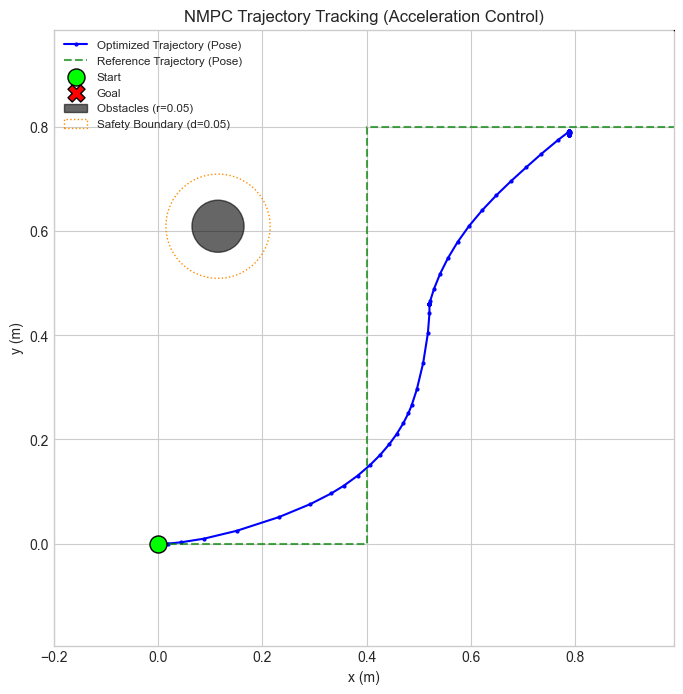

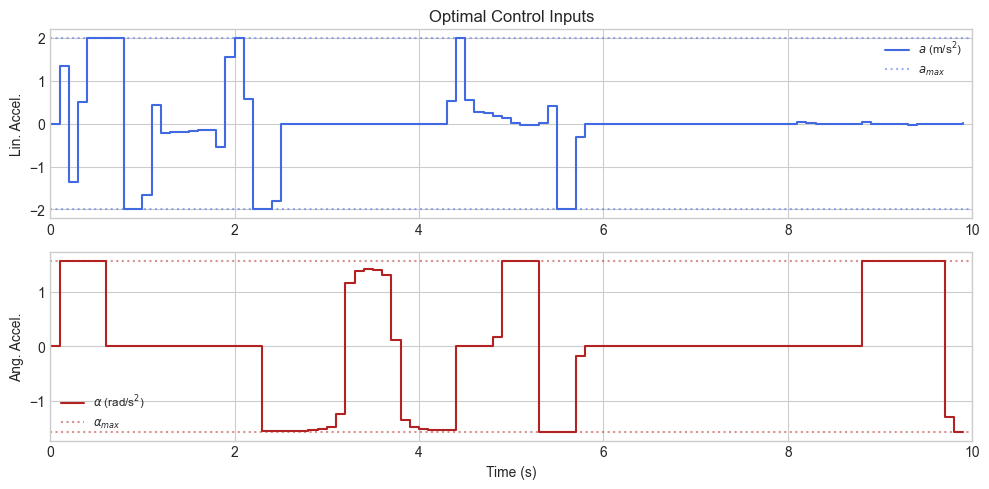

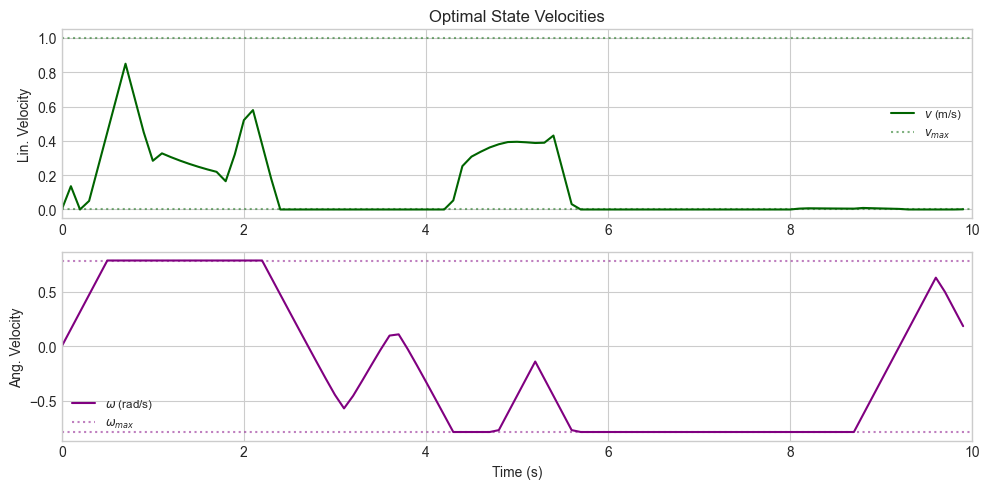

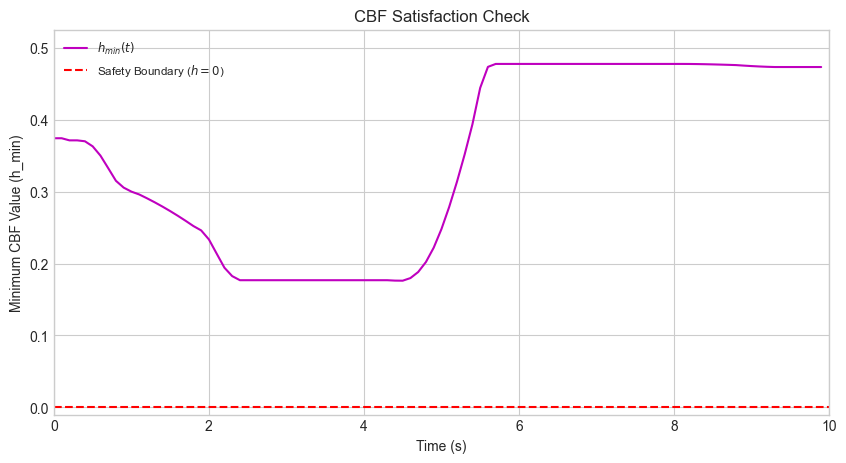

In [21]:
import casadi as cas
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle # Import Circle patch
import time # To time the solver

# Parameters
N = 100  # Prediction horizon
dt = 0.1  # Sampling time (seconds)

# --- NEW State/Control Limits ---
v_max = 1.0  # Maximum linear velocity (m/s) - NOW A STATE CONSTRAINT
ω_max = np.pi / 4  # Maximum angular velocity (rad/s) - NOW A STATE CONSTRAINT
a_max = 2.0  # Maximum linear acceleration (m/s^2) - NEW INPUT BOUND
alpha_max = np.pi / 2 # Maximum angular acceleration (rad/s^2) - NEW INPUT BOUND
# --- End NEW State/Control Limits ---

large_number = cas.inf # Use CasADi infinity for bounds

# --- NEW State Definition ---
nx = 5 # State dimension: [x, y, theta, v, omega]
nu = 2 # Control dimension: [a, alpha]

# Goal state (including zero final velocities)
x_goal = np.array([1.0, 1.0, 0.0, 0.0, 0.0]) # Goal state [x, y, theta, v, omega]

# Initial state (including zero initial velocities)
x_current = np.array([0.0, 0.0, 0.0, 0.0, 0.0])  # [x0, y0, θ0, v0, ω0]
# --- End NEW State Definition ---


# --- Obstacle Parameters ---
num_obstacles = 1 # Adjusted number for potentially different path
obstacle_radius = 0.05 # Radius of the physical obstacle
safe_distance = 0.05   # Minimum distance robot center should maintain from obstacle EDGE
min_dist_from_center = obstacle_radius + safe_distance

# Generate obstacle centers
np.random.seed(43) # Changed seed slightly for variety
obstacle_centers = np.random.rand(num_obstacles, 2) * 1.0
min_start_goal_dist = 0.15
valid_centers = []
for center in obstacle_centers:
     if np.linalg.norm(center - x_current[:2]) > min_dist_from_center + 0.05 and \
        np.linalg.norm(center - x_goal[:2]) > min_dist_from_center + 0.05:
         valid_centers.append(center)
obstacle_centers = np.array(valid_centers)
num_obstacles = obstacle_centers.shape[0]
print(f"Using {num_obstacles} obstacles.")
min_dist_sq_array = np.full(num_obstacles, min_dist_from_center**2)
# Initial violation check... (assume safe for brevity)
# --- End Obstacle Parameters ---


# --- Define Reference Trajectory (3D Pose: x, y, theta) ---
# NOTE: Reference trajectory remains 3D (pose only)
nx_ref = 3 # Dimension of reference state
wp0 = np.array([0.0, 0.0, np.pi/4])
wp1 = np.array([0.4, 0.4, np.pi/4])
wp2 = np.array([0.8, 0.8, np.pi/4])
wp3 = np.array([1.0, 1.0, np.pi/4])

N1, N2, N3 = 25, 45, 30 # Step allocation
if N1 + N2 + N3 > N: # Adjust if needed
    scale = N / (N1 + N2 + N3); N1 = int(N1 * scale); N2 = int(N2 * scale); N3 = N - N1 - N2

X_ref_traj = np.zeros((nx_ref, N)) # Shape (3, N)
t1 = np.linspace(0, 1, N1); X_ref_traj[0, :N1] = wp0[0] + (wp1[0] - wp0[0]) * t1
X_ref_traj[1, :N1] = wp0[1]; X_ref_traj[2, :N1] = wp1[2]
t2 = np.linspace(0, 1, N2); k_start_2 = N1; k_end_2 = N1 + N2
X_ref_traj[0, k_start_2:k_end_2] = wp1[0]; X_ref_traj[1, k_start_2:k_end_2] = wp1[1] + (wp2[1] - wp1[1]) * t2
X_ref_traj[2, k_start_2:k_end_2] = wp2[2]
t3 = np.linspace(0, 1, N3); k_start_3 = N1 + N2; k_end_3 = N1 + N2 + N3
X_ref_traj[0, k_start_3:k_end_3] = wp2[0] + (wp3[0] - wp2[0]) * t3
X_ref_traj[1, k_start_3:k_end_3] = wp2[1]; X_ref_traj[2, k_start_3:k_end_3] = wp3[2]
if k_end_3 < N: X_ref_traj[:, k_end_3:] = wp3.reshape(nx_ref, 1)
# --- End Reference Trajectory ---


# --- NEW Dynamics Function (5D State, Acceleration Inputs) ---
def dynamics(x, u):
    # x = [x, y, theta, v, omega]
    # u = [a, alpha]
    x_pos   = x[0]
    y_pos   = x[1]
    theta   = x[2]
    v       = x[3]  # Velocity from PREVIOUS step
    omega   = x[4]  # Angular velocity from PREVIOUS step
    a       = u[0]  # Linear acceleration input
    alpha   = u[1]  # Angular acceleration input

    x_next = cas.vertcat(
        x_pos + dt * v * cas.cos(theta),    # x_{k+1}
        y_pos + dt * v * cas.sin(theta),    # y_{k+1}
        theta + dt * omega,                 # theta_{k+1}
        v + dt * a,                         # v_{k+1}
        omega + dt * alpha                  # omega_{k+1}
    )
    return x_next
# --- End NEW Dynamics Function ---

# --- Parameters Vector (p) ---
# Contains 5D initial state x0 and 3D reference trajectory X_ref
p = cas.SX.sym('p', nx + nx_ref * N)  # Size 5 + 3*N

# Create the numerical parameter vector p_value
p_value = np.concatenate([x_current, X_ref_traj.ravel()]) # size 5 + 3*N
# --- End Parameters Vector ---


# --- Decision variables Z ---
# Contains controls U (accelerations) and states X (5D)
Z = cas.SX.sym('Z', nu * N + nx * N)  # Size 2*N + 5*N = 7*N
# --- End Decision variables Z ---


# --- Extract variables from Z and p ---
x0 = p[0:nx]                        # Symbolic 5D initial state
X_ref_vec = p[nx:]                  # Symbolic 3D reference trajectory (vectorized)
X_ref = cas.reshape(X_ref_vec, nx_ref, N) # Symbolic 3D reference trajectory (matrix, 3xN)

U = cas.reshape(Z[0:nu * N], nu, N)    # Symbolic Controls [a, alpha] (2xN)
X = cas.reshape(Z[nu * N:], nx, N)     # Symbolic States [x,y,th,v,om] (5xN)
# --- End Extract variables ---


# --- Define the UPDATED cost function ---
cost = cas.SX(0)
# Weights for tracking 3D reference state [x, y, theta]
Q_running = cas.diag([5.0, 5.0, 0.5])
# Weights for acceleration effort [a, alpha] - TUNE THESE
R_running = cas.diag([0.1, 0.1]) # Penalize accelerations less? Or more?
# Weights for final 5D state deviation from goal [x,y,th,v,om]
Q_terminal = cas.diag([50.0, 50.0, 5.0, 10.0, 10.0]) # Add weights for v, omega goal

for k in range(N):
    # Control Cost (penalize acceleration effort)
    # control = U[:, k] # control is [a_k, alpha_k]
    # cost += control.T @ R_running @ control

    # State Cost (penalize deviation of POSE from REFERENCE trajectory X_ref)
    state_error_pose = X[0:2, k] - X_ref[0:2, k] # Compare 3D pose part only
    # theta_error = state_error_pose[2]
    # theta_error_wrapped = cas.atan2(cas.sin(theta_error), cas.cos(theta_error))
    state_cost = Q_running[0,0]*state_error_pose[0]**2 + \
                 Q_running[1,1]*state_error_pose[1]**2 
    cost += 100000*state_cost

# Terminal cost (deviation of FULL 5D state from final goal x_goal)
terminal_state_error = X[:, N-1] - x_goal # Compare full 5D state
terminal_theta_error = terminal_state_error[2]
terminal_theta_error_wrapped = cas.atan2(cas.sin(terminal_theta_error), cas.cos(terminal_theta_error))
# Calculate terminal cost using 5x5 Q_terminal
terminal_cost = Q_terminal[0,0]*terminal_state_error[0]**2 + \
                Q_terminal[1,1]*terminal_state_error[1]**2 + \
                Q_terminal[2,2]*terminal_theta_error_wrapped**2 + \
                Q_terminal[3,3]*terminal_state_error[3]**2 + \
                Q_terminal[4,4]*terminal_state_error[4]**2
cost += terminal_cost
# --- End UPDATED cost function ---


# --- Define UPDATED constraints ---
g = []; lbg = []; ubg = []

# 1. Dynamics Constraints (Now use 5D state)
for k in range(N):
    x_curr_step = X[:, k-1] if k > 0 else x0
    u_curr_step = U[:, k]; x_next_pred = dynamics(x_curr_step, u_curr_step)
    g.append(X[:, k] - x_next_pred)
    lbg.extend([0.0] * nx) # nx is now 5
    ubg.extend([0.0] * nx) # nx is now 5

# 2. CBF Constraints (Depend only on position X[0:2,:], no change needed)
for k in range(N):
    pos_k = X[0:2, k]
    for obs_idx in range(num_obstacles):
        obs_center = obstacle_centers[obs_idx, :]
        min_dist_sq = min_dist_sq_array[obs_idx]
        dist_sq = cas.sumsqr(pos_k - obs_center)
        h_k_obs = dist_sq - min_dist_sq
        g.append(h_k_obs); lbg.append(0.01); ubg.append(large_number)

# 3. State Constraints (Velocity Limits - NEW)
for k in range(N):
    v_k = X[3, k]     # Velocity state v_{k+1}
    omega_k = X[4, k] # Angular velocity state omega_{k+1}
    # Constraint: 0 <= v_k <= v_max
    g.append(v_k)
    lbg.append(0.0)
    ubg.append(v_max)
    # Constraint: -omega_max <= omega_k <= omega_max
    g.append(omega_k)
    lbg.append(-ω_max)
    ubg.append(ω_max)

# --- End UPDATED constraints ---

g = cas.vertcat(*g); lbg = np.array(lbg); ubg = np.array(ubg)

# NLP definition
nlp = {'x': Z, 'p': p, 'f': cost, 'g': g}

# --- Define UPDATED bounds for decision variables (Z) ---
lbz = np.full(Z.shape, -large_number); ubz = np.full(Z.shape, large_number)

# Input Constraints (Acceleration Limits - NEW)
for k in range(N):
    # Bounds for a_k (control input 0)
    lbz[k*nu + 0] = -a_max
    ubz[k*nu + 0] = a_max
    # Bounds for alpha_k (control input 1)
    lbz[k*nu + 1] = -alpha_max
    ubz[k*nu + 1] = alpha_max

# State Variable Bounds (Optional: Add bounds on x, y, theta if needed)
# Example: Workspace limits for x position
# lbz[nu*N + 0 : nu*N + nx*N : nx] = -workspace_x_limit
# ubz[nu*N + 0 : nu*N + nx*N : nx] = workspace_x_limit

# Initial Acceleration Constraint: U[:, 0] = [0, 0] (optional, but good start)
lbz[0] = 0.0; ubz[0] = 0.0 # a_0 = 0
lbz[1] = 0.0; ubz[1] = 0.0 # alpha_0 = 0
print(f"Constraining initial control U[:,0] (accelerations) to zero.")
# --- End UPDATED bounds ---


# Solver
solver_opts = {'ipopt': {'print_level': 0, 'sb': 'yes', 'max_iter': 3000, 'tol': 1e-4}}
solver = cas.nlpsol('solver', 'ipopt', nlp, solver_opts)

# Initial guess
Z0 = np.zeros(Z.shape) # Z0 will have shape (700, 1)

# Provide a guess based on reference trajectory (can sometimes help)
# Reshape the source arrays to column vectors (100, 1) to match the slice shape
Z0[nu*N + 0 : nu*N + nx*N : nx] = X_ref_traj[0,:].reshape(-1, 1) # x pos guess
Z0[nu*N + 1 : nu*N + nx*N : nx] = X_ref_traj[1,:].reshape(-1, 1) # y pos guess
Z0[nu*N + 2 : nu*N + nx*N : nx] = X_ref_traj[2,:].reshape(-1, 1) # theta guess
# Keep v, omega guess at 0 (already handled by np.zeros)

# --- Solve ---
print("\n--- Starting Solver ---")
start_time = time.time()
try:
    sol = solver(x0=Z0, p=p_value, lbx=lbz, ubx=ubz, lbg=lbg, ubg=ubg)
    solve_time = time.time() - start_time
    Z_opt = sol['x'].full().flatten(); stats = solver.stats()
    if stats['success']: print(f"Solver found optimal solution in {solve_time:.2f} seconds.")
    else: print(f"Solver finished with status: {stats['return_status']} in {solve_time:.2f} seconds.")

    # --- Extract optimal solution ---
    U_opt = Z_opt[0:nu * N].reshape(N, nu).T       # Optimal accelerations [a, alpha]
    X_opt = Z_opt[nu * N:].reshape(N, nx).T       # Optimal states [x,y,th,v,om]
    X_plot = np.hstack((x_current.reshape(nx, 1), X_opt)) # Prepend initial state (5D)

    # CBF Calculation (no change needed, uses X_opt[0:2,:])
    h_values = np.zeros((num_obstacles, N))
    for k in range(N):
        pos_k_opt = X_opt[0:2, k]
        for obs_idx in range(num_obstacles):
            obs_center = obstacle_centers[obs_idx, :]
            min_dist_sq = min_dist_sq_array[obs_idx]
            dist_sq_opt = np.sum((pos_k_opt - obs_center)**2)
            h_values[obs_idx, k] = dist_sq_opt - min_dist_sq
    min_h_values = np.min(h_values, axis=0)
    min_overall_h = np.min(min_h_values)
    print(f"Minimum CBF value (h_min) reached: {min_overall_h:.4f}")
    if min_overall_h < -1e-4: print("WARNING: Safety constraint violated!")
    else: print("Safety constraint satisfied.")

    # --- Plotting ---
    plt.style.use('seaborn-v0_8-whitegrid')
    time_steps = np.arange(N) * dt

    # Plot 1: Trajectories (Pose)
    plt.figure(figsize=(8, 8))
    ax1 = plt.gca()
    plt.plot(X_plot[0, :], X_plot[1, :], 'b-', marker='.', markersize=4, linewidth=1.5, label='Optimized Trajectory (Pose)')
    plt.plot(X_ref_traj[0, :], X_ref_traj[1, :], 'g--', alpha=0.7, linewidth=1.5, label='Reference Trajectory (Pose)')
    plt.scatter(x_current[0], x_current[1], c='lime', marker='o', s=150, label='Start', zorder=10, edgecolors='black')
    plt.scatter(x_goal[0], x_goal[1], c='red', marker='X', s=150, label='Goal', zorder=10, edgecolors='black')
    for i in range(num_obstacles): # Draw obstacles
        obstacle_patch = Circle(obstacle_centers[i], obstacle_radius, color='black', alpha=0.6, zorder=5)
        ax1.add_patch(obstacle_patch)
        safety_circle = Circle(obstacle_centers[i], min_dist_from_center, color='darkorange', fill=False, linestyle=':', linewidth=1.0, zorder=4)
        ax1.add_patch(safety_circle)
    ax1.add_patch(Circle((0,0), 0.01, color='black', alpha=0.6, label=f'Obstacles (r={obstacle_radius:.2f})'))
    ax1.add_patch(Circle((0,0), 0.01, color='darkorange', fill=False, linestyle=':', label=f'Safety Boundary (d={safe_distance:.2f})'))
    plt.xlabel('x (m)'); plt.ylabel('y (m)'); plt.title('NMPC Trajectory Tracking (Acceleration Control)')
    plt.legend(fontsize='small', loc='best'); plt.axis('equal'); plt.grid(True)
    plt.xlim(np.min(X_plot[0,:])-0.2, np.max(X_plot[0,:])+0.2) # Auto limits
    plt.ylim(np.min(X_plot[1,:])-0.2, np.max(X_plot[1,:])+0.2)

    # Plot 2: Control Inputs (Accelerations)
    plt.figure(figsize=(10, 5))
    plt.subplot(2, 1, 1)
    plt.step(time_steps, U_opt[0, :], color='royalblue', where='post', linewidth=1.5, label='$a$ (m/s$^2$)')
    plt.axhline(a_max, color='royalblue', linestyle=':', alpha=0.5, label='$a_{max}$')
    plt.axhline(-a_max, color='royalblue', linestyle=':', alpha=0.5)
    plt.ylabel('Lin. Accel.'); plt.title('Optimal Control Inputs'); plt.legend(fontsize='small'); plt.grid(True); plt.xlim(0, N*dt)
    plt.subplot(2, 1, 2)
    plt.step(time_steps, U_opt[1, :], color='firebrick', where='post', linewidth=1.5, label='$\\alpha$ (rad/s$^2$)')
    plt.axhline(alpha_max, color='firebrick', linestyle=':', alpha=0.5, label='$\\alpha_{max}$')
    plt.axhline(-alpha_max, color='firebrick', linestyle=':', alpha=0.5)
    plt.xlabel('Time (s)'); plt.ylabel('Ang. Accel.'); plt.legend(fontsize='small'); plt.grid(True); plt.xlim(0, N*dt)
    plt.tight_layout()


    # Plot 3: State Velocities
    plt.figure(figsize=(10, 5))
    plt.subplot(2, 1, 1)
    plt.plot(time_steps, X_opt[3, :], color='darkgreen', linewidth=1.5, label='$v$ (m/s)')
    plt.axhline(v_max, color='darkgreen', linestyle=':', alpha=0.5, label='$v_{max}$')
    plt.axhline(0, color='darkgreen', linestyle=':', alpha=0.5)
    plt.ylabel('Lin. Velocity'); plt.title('Optimal State Velocities'); plt.legend(fontsize='small'); plt.grid(True); plt.xlim(0, N*dt)
    plt.subplot(2, 1, 2)
    plt.plot(time_steps, X_opt[4, :], color='purple', linewidth=1.5, label='$\\omega$ (rad/s)')
    plt.axhline(ω_max, color='purple', linestyle=':', alpha=0.5, label='$\\omega_{max}$')
    plt.axhline(-ω_max, color='purple', linestyle=':', alpha=0.5)
    plt.xlabel('Time (s)'); plt.ylabel('Ang. Velocity'); plt.legend(fontsize='small'); plt.grid(True); plt.xlim(0, N*dt)
    plt.tight_layout()


    # Plot 4: Minimum CBF Value (h_min)
    plt.figure(figsize=(10, 5))
    plt.plot(time_steps, min_h_values, 'm-', linewidth=1.5, label='$h_{min}(t)$')
    plt.axhline(0, color='r', linestyle='--', linewidth=1.5, label='Safety Boundary ($h=0$)')
    plt.xlabel('Time (s)'); plt.ylabel('Minimum CBF Value (h_min)'); plt.title('CBF Satisfaction Check')
    plt.legend(fontsize='small'); plt.grid(True)
    min_y = min(np.min(min_h_values), -0.01); max_y = max(np.max(min_h_values) * 1.1, 0.1)
    plt.ylim([min_y, max_y]); plt.xlim(0, N*dt)

    plt.show() # Display all figures

except Exception as e:
    print(f"\n--- ERROR ---"); import traceback; traceback.print_exc()


--- Starting NMPC Simulation ---
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0) 603.00us ( 15.46us)        39
       nlp_g  |        0 (       0) 705.00us ( 18.08us)        39
  nlp_grad_f  |        0 (       0)   1.05ms ( 25.61us)        41
  nlp_hess_l  |        0 (       0)   2.14ms ( 56.37us)        38
   nlp_jac_g  |        0 (       0)   1.13ms ( 28.37us)        40
       total  | 149.00ms (149.00ms) 159.00ms (159.00ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0) 243.00us ( 12.79us)        19
       nlp_g  |        0 (       0) 266.00us ( 14.00us)        19
  nlp_grad_f  |        0 (       0) 423.00us ( 21.15us)        20
  nlp_hess_l  |        0 (       0) 826.00us ( 48.59us)        17
   nlp_jac_g  |        0 (       0) 421.00us ( 22.16us)        19
       total  |  67.00ms ( 67.00ms)  58.16ms ( 58.16ms)         1
      solver  :   t_proc      (avg)   t_wa

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0) 113.00us ( 10.27us)        11
       nlp_g  |        0 (       0) 118.00us ( 10.73us)        11
  nlp_grad_f  |        0 (       0) 224.00us ( 17.23us)        13
  nlp_hess_l  |        0 (       0) 377.00us ( 37.70us)        10
   nlp_jac_g  |        0 (       0) 216.00us ( 18.00us)        12
       total  |  27.00ms ( 27.00ms)  26.97ms ( 26.97ms)         1
Sim Step: 200/200, Time: 20.0s, Goal Dist: 1.414

Maximum simulation time reached.
--- Simulation Finished (Total Time: 9.21s) ---


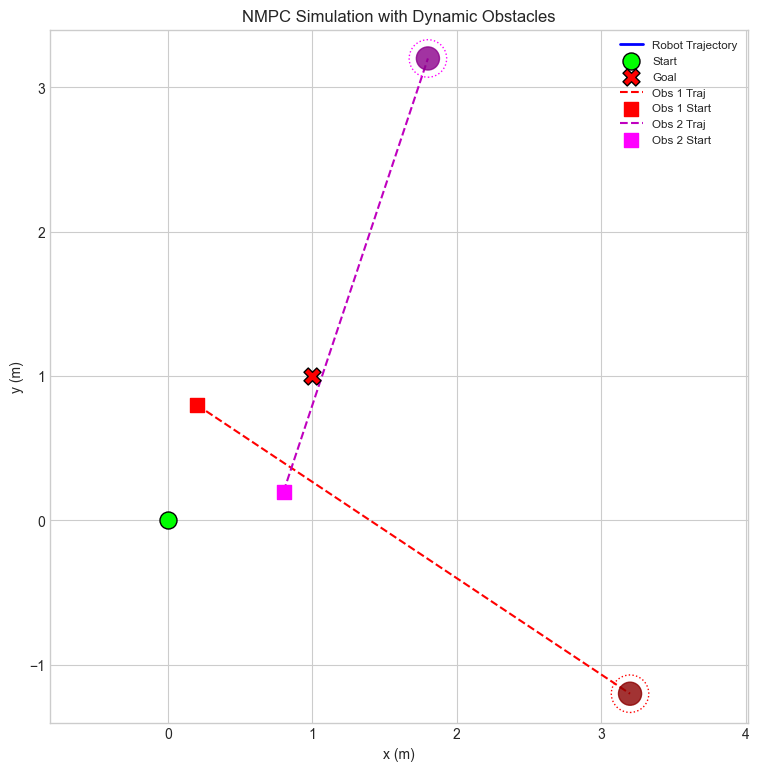

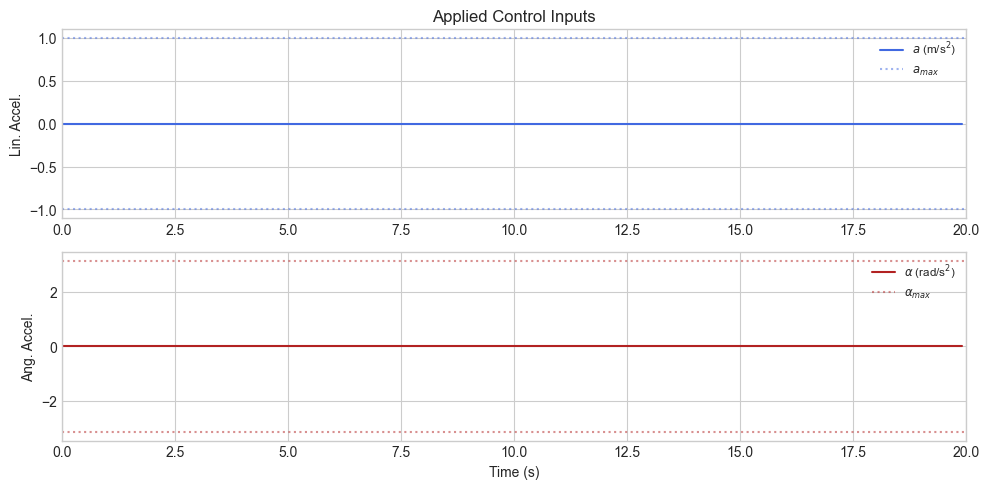

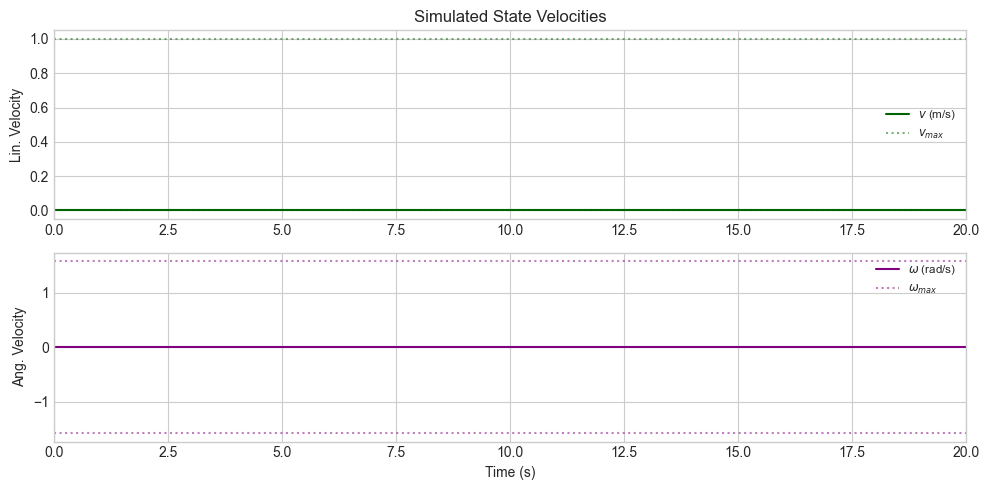

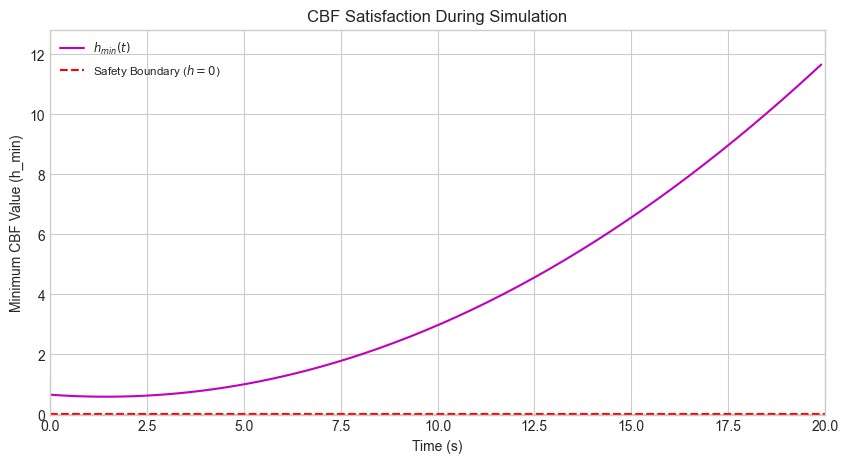

In [54]:
import casadi as cas
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
import matplotlib.animation as animation # For animation (optional)
import time

# Parameters
N = 50   # Prediction horizon (Shorter horizon for faster solves in loop)
dt = 0.1  # Sampling time (seconds)

# Robot Limits (State and Control)
v_max = 1.0  # Max linear velocity (m/s) - STATE CONSTRAINT
ω_max = np.pi / 2  # Max angular velocity (rad/s) (~90 deg/s) - STATE CONSTRAINT
a_max = 1.0  # Max linear acceleration (m/s^2) - INPUT BOUND
alpha_max = np.pi # Max angular acceleration (rad/s^2) (~180 deg/s^2) - INPUT BOUND

large_number = cas.inf

# State/Control Dimensions
nx = 5 # State: [x, y, theta, v, omega]
nu = 2 # Control: [a, alpha]

# Goal state (Pose only needed for target)
x_goal_pose = np.array([1.0, 1.0, 0.0]) # Target pose [x, y, theta]
# Target state includes zero velocities for cost function Q_terminal
x_goal_target_state = np.array([1.0, 1.0, 0.0, 0.0, 0.0])

# Initial state (at rest)
x_current = np.array([0.0, 0.0, 0.0, 0.0, 0.0])

# --- Dynamic Obstacle Parameters ---
num_dyn_obstacles = 2
obstacle_radius = 0.08 # Slightly larger obstacles
safe_distance = 0.05   # Minimum distance robot edge should maintain
min_dist_from_center = obstacle_radius + safe_distance
min_dist_sq = min_dist_from_center**2

# Obstacle 1: Starts near (0.2, 0.8), moves diagonally down-right
obs1_init_pos = np.array([0.2, 0.8])
obs1_vel = np.array([0.15, -0.1]) # vx, vy

# Obstacle 2: Starts near (0.8, 0.2), moves diagonally up-right
obs2_init_pos = np.array([0.8, 0.2])
obs2_vel = np.array([0.05, 0.15]) # vx, vy

# Function to predict obstacle position at a future time
def predict_obstacle_pos(initial_pos, velocity, time_offset):
    # Simple linear motion: pos(t) = pos0 + vel * t
    return initial_pos + velocity * time_offset

# --- End Dynamic Obstacle Parameters ---


# --- Dynamics Function (CasADi version for NLP) ---
def dynamics_casadi(x, u):
    v = x[3]; omega = x[4]; theta = x[2]; a = u[0]; alpha = u[1]
    x_next = cas.vertcat(
        x[0] + dt * v * cas.cos(theta), x[1] + dt * v * cas.sin(theta),
        theta + dt * omega, v + dt * a, omega + dt * alpha
    )
    return x_next
# --- Dynamics Function (NumPy version for Simulation) ---
def dynamics_numpy(x, u):
    v = x[3]; omega = x[4]; theta = x[2]; a = u[0]; alpha = u[1]
    x_next = np.array([
        x[0] + dt * v * np.cos(theta), x[1] + dt * v * np.sin(theta),
        theta + dt * omega, v + dt * a, omega + dt * alpha
    ])
     # Enforce state constraints after simulation step (simple clipping)
    x_next[3] = np.clip(x_next[3], 0.0, v_max) # Velocity >= 0
    x_next[4] = np.clip(x_next[4], -ω_max, ω_max)
    return x_next
# --- End Dynamics Functions ---


# --- Build the NMPC Optimization Problem ---
# Symbolic variables
U_sym = cas.SX.sym('U', nu, N)       # Controls (accelerations)
X_sym = cas.SX.sym('X', nx, N + 1)   # States (pose + velocities)

# Parameter vector 'p': initial state x0 + predicted obstacle centers over N steps
# Size = nx + (num_dyn_obstacles * 2 * N) = 5 + (2 * 2 * 50) = 205
num_obs_coords = num_dyn_obstacles * 2 # 2 obstacles * 2 coords (x,y)
p = cas.SX.sym('p', nx + num_obs_coords * N)

# Extract parameters
x0_sym = p[0:nx]                                    # Symbolic initial state
obs_pred_centers_flat = p[nx:]                      # All predicted centers flattened
obs_pred_centers_sym = cas.reshape(obs_pred_centers_flat, num_obs_coords, N) # Shape (4, N)

# Cost function weights
Q_pose = cas.diag([5.0, 5.0, 0.5]) # Pose tracking [x, y, theta]
R_accel = cas.diag([0.1, 0.1])   # Acceleration effort [a, alpha] TUNE
Q_term_pose = cas.diag([50.0, 50.0, 5.0]) # Terminal pose tracking TUNE
Q_term_vel = cas.diag([10.0, 10.0])       # Terminal velocity penalty TUNE

cost = cas.SX(0)
g = []  # Constraint list
lbg = []; ubg = [] # Constraint bounds lists

# Initial state constraint
g.append(X_sym[:, 0] - x0_sym)
lbg.extend([0.0] * nx); ubg.extend([0.0] * nx)

# Build NLP costs and constraints over the horizon N
for k in range(N):
    x_k = X_sym[:, k]; u_k = U_sym[:, k]; x_k_next = X_sym[:, k+1]

    # --- Cost Function Terms ---
    # Control cost (acceleration effort)
    cost += u_k.T @ R_accel @ u_k
    # State cost (deviation from final goal pose - simpler than tracking ref here)
    state_error_pose = x_k[0:3] - x_goal_pose # Deviation from final pose goal
    theta_error = state_error_pose[2]
    theta_error_wrapped = cas.atan2(cas.sin(theta_error), cas.cos(theta_error))
    cost += Q_pose[0,0]*state_error_pose[0]**2 + \
            Q_pose[1,1]*state_error_pose[1]**2 + \
            Q_pose[2,2]*theta_error_wrapped**2

    # --- Constraints ---
    # Dynamics
    x_next_pred = dynamics_casadi(x_k, u_k)
    g.append(x_k_next - x_next_pred)
    lbg.extend([0.0] * nx); ubg.extend([0.0] * nx)

    # State Constraints (Velocities) applied to X_sym[:, k+1] (state at END of interval)
    v_k_next = x_k_next[3]
    omega_k_next = x_k_next[4]
    g.append(v_k_next)
    lbg.append(0.0); ubg.append(v_max)
    g.append(omega_k_next)
    lbg.append(-ω_max); ubg.append(ω_max)

    # CBF Constraints (Dynamic Obstacles) applied to X_sym[:, k+1]
    pos_k_next = x_k_next[0:2]
    # Extract predicted centers for obs1 and obs2 at step k
    obs1_center_k = obs_pred_centers_sym[0:2, k]
    obs2_center_k = obs_pred_centers_sym[2:4, k]

    # CBF for Obstacle 1
    dist_sq1 = cas.sumsqr(pos_k_next - obs1_center_k)
    h_k_obs1 = dist_sq1 - min_dist_sq
    g.append(h_k_obs1); lbg.append(0.0); ubg.append(large_number)

    # CBF for Obstacle 2
    dist_sq2 = cas.sumsqr(pos_k_next - obs2_center_k)
    h_k_obs2 = dist_sq2 - min_dist_sq
    g.append(h_k_obs2); lbg.append(0.0); ubg.append(large_number)

# Terminal Cost (penalize deviation from final goal state including velocities)
x_N = X_sym[:, N]
term_error_pose = x_N[0:3] - x_goal_pose
term_theta_err = term_error_pose[2]
term_theta_err_wrap = cas.atan2(cas.sin(term_theta_err), cas.cos(term_theta_err))
term_vel_error = x_N[3:5] # Deviation from zero velocity goal

cost += term_error_pose[0]**2 * Q_term_pose[0,0] + \
        term_error_pose[1]**2 * Q_term_pose[1,1] + \
        term_theta_err_wrap**2 * Q_term_pose[2,2] + \
        term_vel_error[0]**2 * Q_term_vel[0,0] + \
        term_vel_error[1]**2 * Q_term_vel[1,1]


# Create NLP solver interface
nlp_dict = {
    'f': cost,
    'x': cas.vertcat(cas.vec(X_sym), cas.vec(U_sym)), # Decision variables [X0..XN, U0..UN-1]
    'p': p,                                            # Parameters [x0, obs_preds]
    'g': cas.vertcat(*g)                               # Constraints
}

# Solver options
solver_opts = {'ipopt': {'print_level': 0, 'sb': 'yes', 'max_iter': 1000, 'tol': 1e-4}}
solver = cas.nlpsol('solver', 'ipopt', nlp_dict, solver_opts)

# --- Define Bounds ---
lbx = np.full(nx*(N+1) + nu*N, -large_number)
ubx = np.full(nx*(N+1) + nu*N, large_number)

# Input (acceleration) bounds
for k in range(N):
    lbx[nx*(N+1) + k*nu + 0] = -a_max; ubx[nx*(N+1) + k*nu + 0] = a_max  # a bounds
    lbx[nx*(N+1) + k*nu + 1] = -alpha_max; ubx[nx*(N+1) + k*nu + 1] = alpha_max # alpha bounds

# Initial acceleration constraint (optional)
lbx[nx*(N+1) + 0] = 0.0; ubx[nx*(N+1) + 0] = 0.0 # a_0
lbx[nx*(N+1) + 1] = 0.0; ubx[nx*(N+1) + 1] = 0.0 # alpha_0

# Combine constraint bounds
lbg_np = np.array(lbg); ubg_np = np.array(ubg)

# --- End NMPC Problem Build ---


# --- Simulation Loop ---
sim_time_max = 20.0 # Maximum simulation time (seconds)
mpc_steps = int(sim_time_max / dt)

# History storage
state_history = np.zeros((nx, mpc_steps + 1))
control_history = np.zeros((nu, mpc_steps))
obs1_pos_history = np.zeros((2, mpc_steps + 1))
obs2_pos_history = np.zeros((2, mpc_steps + 1))
time_history = np.zeros(mpc_steps + 1)
min_h_history = np.zeros(mpc_steps) # Store min h value at each step

# Initial conditions for simulation
current_state = x_current
state_history[:, 0] = current_state
obs1_current_pos = obs1_init_pos
obs2_current_pos = obs2_init_pos
obs1_pos_history[:, 0] = obs1_current_pos
obs2_pos_history[:, 0] = obs2_current_pos
time_history[0] = 0.0

# Initial guess for decision variables (states and controls)
X_guess = np.tile(current_state, (N + 1, 1)).T # Repeat initial state
U_guess = np.zeros((nu, N))
Z_guess = np.concatenate([X_guess.ravel(order='F'), U_guess.ravel(order='F')]) #'F' for Fortran order matching CasADi vec

print("\n--- Starting NMPC Simulation ---")
sim_start_time = time.time()

for i in range(mpc_steps):
    current_time = i * dt
    time_history[i+1] = current_time + dt

    # 1. Predict future obstacle positions for the horizon N
    pred_obs1_centers = np.array([predict_obstacle_pos(obs1_current_pos, obs1_vel, k*dt) for k in range(N)]).T # Shape (2, N)
    pred_obs2_centers = np.array([predict_obstacle_pos(obs2_current_pos, obs2_vel, k*dt) for k in range(N)]).T # Shape (2, N)
    # Flatten predictions for parameter vector p
    obs_pred_flat = np.concatenate([pred_obs1_centers.ravel(), pred_obs2_centers.ravel()])

    # 2. Construct parameter vector p_value
    p_value = np.concatenate([current_state, obs_pred_flat])

    # 3. Solve the NLP
    try:
        sol = solver(x0=Z_guess, p=p_value, lbx=lbx, ubx=ubx, lbg=lbg_np, ubg=ubg_np)
        Z_opt = sol['x'].full().flatten()
        status = solver.stats()['return_status']
        if status != 'Solve_Succeeded':
            print(f"Warning: Solver finished step {i} with status: {status}")
            # Option: reuse previous control or stop simulation
            if i > 0: u_apply = control_history[:, i-1]
            else: u_apply = np.zeros(nu)
        else:
            # Extract optimal controls and states
            U_opt = Z_opt[nx*(N+1):].reshape(N, nu).T # Shape (nu, N)
            # Extract ONLY the first optimal control input
            u_apply = U_opt[:, 0]
            # Use solution as next guess (warm start)
            Z_guess = Z_opt # Note: Might need shifting for receding horizon if formulation changes

    except Exception as e:
        print(f"Error during optimization at step {i}: {e}")
        # Option: reuse previous control or stop simulation
        if i > 0: u_apply = control_history[:, i-1]
        else: u_apply = np.zeros(nu)


    # Clip applied control just in case solver slightly violates bounds
    u_apply[0] = np.clip(u_apply[0], -a_max, a_max)
    u_apply[1] = np.clip(u_apply[1], -alpha_max, alpha_max)

    # 4. Store applied control
    control_history[:, i] = u_apply

    # 5. Simulate the system one step forward using NumPy dynamics
    next_state = dynamics_numpy(current_state, u_apply)

    # 6. Update system state
    current_state = next_state
    state_history[:, i+1] = current_state

    # 7. Update actual obstacle positions for the next iteration
    obs1_current_pos = predict_obstacle_pos(obs1_init_pos, obs1_vel, current_time + dt)
    obs2_current_pos = predict_obstacle_pos(obs2_init_pos, obs2_vel, current_time + dt)
    obs1_pos_history[:, i+1] = obs1_current_pos
    obs2_pos_history[:, i+1] = obs2_current_pos

    # 8. Calculate and store minimum h value for this step (optional analysis)
    dist_sq1_now = np.sum((current_state[0:2] - obs1_current_pos)**2)
    dist_sq2_now = np.sum((current_state[0:2] - obs2_current_pos)**2)
    h1_now = dist_sq1_now - min_dist_sq
    h2_now = dist_sq2_now - min_dist_sq
    min_h_history[i] = min(h1_now, h2_now)


    # 9. Check termination condition (distance to goal pose)
    goal_dist = np.linalg.norm(current_state[0:2] - x_goal_pose[0:2])
    if goal_dist < 0.05: # Stop if close enough to goal position
        print(f"\nGoal reached at step {i+1} (Time: {current_time + dt:.2f}s)")
        # Trim history arrays
        state_history = state_history[:, :i+2]
        control_history = control_history[:, :i+1]
        obs1_pos_history = obs1_pos_history[:, :i+2]
        obs2_pos_history = obs2_pos_history[:, :i+2]
        time_history = time_history[:i+2]
        min_h_history = min_h_history[:i+1]
        break

    # Print progress
    if (i+1) % 10 == 0:
         print(f"Sim Step: {i+1}/{mpc_steps}, Time: {current_time + dt:.1f}s, Goal Dist: {goal_dist:.3f}")

else: # If loop finishes without break
    print("\nMaximum simulation time reached.")

sim_end_time = time.time()
print(f"--- Simulation Finished (Total Time: {sim_end_time - sim_start_time:.2f}s) ---")

# --- Plotting Results ---
plt.style.use('seaborn-v0_8-whitegrid')
final_steps = state_history.shape[1]
sim_time_vector = time_history[:final_steps] # Time vector for state/obstacle plots
control_time_vector = time_history[:final_steps-1] # Time vector for control plots

# Plot 1: Trajectories (Robot and Obstacles)
plt.figure(figsize=(9, 9))
ax1 = plt.gca()
# Plot Robot Trajectory
plt.plot(state_history[0, :], state_history[1, :], 'b-', linewidth=2, label='Robot Trajectory')
plt.scatter(state_history[0, 0], state_history[1, 0], c='lime', marker='o', s=150, label='Start', zorder=10, edgecolors='black')
plt.scatter(x_goal_pose[0], x_goal_pose[1], c='red', marker='X', s=150, label='Goal', zorder=10, edgecolors='black')
# Plot Obstacle 1 Trajectory
plt.plot(obs1_pos_history[0, :], obs1_pos_history[1, :], 'r--', linewidth=1.5, label='Obs 1 Traj')
plt.scatter(obs1_pos_history[0, 0], obs1_pos_history[1, 0], c='red', marker='s', s=100, label='Obs 1 Start', zorder=8)
# Plot Obstacle 2 Trajectory
plt.plot(obs2_pos_history[0, :], obs2_pos_history[1, :], 'm--', linewidth=1.5, label='Obs 2 Traj')
plt.scatter(obs2_pos_history[0, 0], obs2_pos_history[1, 0], c='magenta', marker='s', s=100, label='Obs 2 Start', zorder=8)

# Draw final positions with safety circles
# Robot final
robot_final_patch = Circle(state_history[0:2, -1], 0.03, color='blue', alpha=0.7, zorder=7)
ax1.add_patch(robot_final_patch)
# Obstacle 1 final
obs1_final_patch = Circle(obs1_pos_history[:, -1], obstacle_radius, color='darkred', alpha=0.8, zorder=6)
ax1.add_patch(obs1_final_patch)
safety1_final_patch = Circle(obs1_pos_history[:, -1], min_dist_from_center, color='red', fill=False, linestyle=':', linewidth=1.0, zorder=5)
ax1.add_patch(safety1_final_patch)
# Obstacle 2 final
obs2_final_patch = Circle(obs2_pos_history[:, -1], obstacle_radius, color='darkmagenta', alpha=0.8, zorder=6)
ax1.add_patch(obs2_final_patch)
safety2_final_patch = Circle(obs2_pos_history[:, -1], min_dist_from_center, color='magenta', fill=False, linestyle=':', linewidth=1.0, zorder=5)
ax1.add_patch(safety2_final_patch)

plt.xlabel('x (m)'); plt.ylabel('y (m)'); plt.title('NMPC Simulation with Dynamic Obstacles')
plt.legend(fontsize='small', loc='best'); plt.axis('equal'); plt.grid(True)
# Adjust limits based on actual trajectories
all_x = np.concatenate([state_history[0, :], obs1_pos_history[0, :], obs2_pos_history[0, :]])
all_y = np.concatenate([state_history[1, :], obs1_pos_history[1, :], obs2_pos_history[1, :]])
plt.xlim(np.min(all_x)-0.2, np.max(all_x)+0.2)
plt.ylim(np.min(all_y)-0.2, np.max(all_y)+0.2)


# Plot 2: Control Inputs (Accelerations) over Time
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.step(control_time_vector, control_history[0, :], color='royalblue', where='post', lw=1.5, label='$a$ (m/s$^2$)')
plt.axhline(a_max, c='royalblue', ls=':', alpha=0.5, label='$a_{max}$'); plt.axhline(-a_max, c='royalblue', ls=':', alpha=0.5)
plt.ylabel('Lin. Accel.'); plt.title('Applied Control Inputs'); plt.legend(fontsize='small'); plt.grid(True); plt.xlim(0, sim_time_vector[-1])
plt.subplot(2, 1, 2)
plt.step(control_time_vector, control_history[1, :], color='firebrick', where='post', lw=1.5, label='$\\alpha$ (rad/s$^2$)')
plt.axhline(alpha_max, c='firebrick', ls=':', alpha=0.5, label='$\\alpha_{max}$'); plt.axhline(-alpha_max, c='firebrick', ls=':', alpha=0.5)
plt.xlabel('Time (s)'); plt.ylabel('Ang. Accel.'); plt.legend(fontsize='small'); plt.grid(True); plt.xlim(0, sim_time_vector[-1])
plt.tight_layout()


# Plot 3: State Velocities over Time
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(sim_time_vector, state_history[3, :], color='darkgreen', lw=1.5, label='$v$ (m/s)')
plt.axhline(v_max, c='darkgreen', ls=':', alpha=0.5, label='$v_{max}$'); plt.axhline(0, c='darkgreen', ls=':', alpha=0.5)
plt.ylabel('Lin. Velocity'); plt.title('Simulated State Velocities'); plt.legend(fontsize='small'); plt.grid(True); plt.xlim(0, sim_time_vector[-1])
plt.subplot(2, 1, 2)
plt.plot(sim_time_vector, state_history[4, :], color='purple', lw=1.5, label='$\\omega$ (rad/s)')
plt.axhline(ω_max, c='purple', ls=':', alpha=0.5, label='$\\omega_{max}$'); plt.axhline(-ω_max, c='purple', ls=':', alpha=0.5)
plt.xlabel('Time (s)'); plt.ylabel('Ang. Velocity'); plt.legend(fontsize='small'); plt.grid(True); plt.xlim(0, sim_time_vector[-1])
plt.tight_layout()


# Plot 4: Minimum CBF Value (h_min) over Time
plt.figure(figsize=(10, 5))
plt.plot(control_time_vector, min_h_history, 'm-', linewidth=1.5, label='$h_{min}(t)$') # Use control time vector here
plt.axhline(0, color='r', linestyle='--', linewidth=1.5, label='Safety Boundary ($h=0$)')
plt.xlabel('Time (s)'); plt.ylabel('Minimum CBF Value (h_min)'); plt.title('CBF Satisfaction During Simulation')
plt.legend(fontsize='small'); plt.grid(True)
min_y = min(np.min(min_h_history), -0.01); max_y = max(np.max(min_h_history) * 1.1, 0.1)
plt.ylim([min_y, max_y]); plt.xlim(0, sim_time_vector[-1])


plt.show()